In [1]:
#
# NOTE: This deep learning program is for predicting TC formation, using
#       input dataset in the NETCDF format and the ResNet50 architechture. 
#       The program treats different 2D input fields as different channels 
#       of an image. This ResNet program requires a set of 12 2D-variables 
#       (12-channel image) and consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a 
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data. 
#
# INPUT: This Stage 1 script requires two specific input datasets, including
#       1. 12 meterological vars u, v, abs vort, tmp, RH, vvels, sst, cape  
#          corresponding to negative cases (i.e. no TC formation within the 
#          domain). The data must be given as an array of 30x30, with a 
#          resolution of 1 degree.
#       2. Similar data but for positive cases (i.e., there is a TC centered
#          on the domain)  
# 
#        Remarks: Note that these data must be on the standard 19 vertical
#        levels 1000, 975, 950, 925, 900, 850, 800, 750, 700, 650, 600, 
#        550, 500, 450, 400, 350, 300, 250, 200. Also, all field vars must
#        be resize to cover an area of 30x30 around the TC center for the 
#        positive data cases.
#
# OUTPUT: A set of pairs (X,y) needed for ResNet training
#
# HIST: - 29, May, 23: Updated for ResNet architechture from the CNN model
#       - 08, Jun, 23: refined for better workflow
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu) 
#==========================================================================
import netCDF4
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
#
# define data source and reading pos/neg data 
#
IMG_SIZE = 30
nchannels = 12
leadtime = "00h"
rootdir="/N/slate/ckieu/deep-learning/data/ncep_binary_30x30_" + leadtime + "/training/"
tcg_class = ['pos','neg']
array_raw = []
for tcg in tcg_class:
    if tcg == "pos":
        datadir=rootdir + 'pos'
    else:
        datadir=rootdir + 'neg'
    print('Input data dir is: ',datadir)
    for img in tqdm(os.listdir(datadir)):
        try:
            print('Processing file:', img)           
            file=datadir+'/'+img
            f = netCDF4.Dataset(file)
            abv = f.variables['absvprs']
            nx = np.size(abv[0,0,:])
            ny = np.size(abv[0,:,0])
            nz = np.size(abv[:,0,0])
            print('nx = ',nx,' ny = ',ny )             
            a2 = np.zeros((nx,ny,nchannels))         
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
            rel = f.variables['rhprs'] 
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,1] = rel[7,j,i]    # RH at 750 mb 
            sfc = f.variables['pressfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,2] = sfc[j,i]      # surface pressure
            tmp = f.variables['tmpprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
            tsf = f.variables['tmpsfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,4] = tsf[j,i]      # surface temperature
            ugr = f.variables['ugrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
                    a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
            vgr = f.variables['vgrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
                    a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
            hgt = f.variables['hgtprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
            wgr = f.variables['vvelprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
                    a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
            a3 = cv2.resize(a2, (IMG_SIZE, IMG_SIZE)) 
            print('a3 shape is :',a3.shape)
            #input('Enter to continue...')
            if tcg == "pos":
                array_raw.append([a3, 1])
            else:
                array_raw.append([a3, 0])
        except Exception as e:
            pass

Input data dir is:  /N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/pos


  0%|                                                                                                          | 0/352 [00:00<?, ?it/s]

Processing file: 20140905_06_00_18.6_128.5_2014248N19129.nc
nx =  30  ny =  30


  0%|▎                                                                                                 | 1/352 [00:01<11:39,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100913_06_00_16.6_137.4_2010256N17137.nc
nx =  30  ny =  30


  1%|▌                                                                                                 | 2/352 [00:03<11:27,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120713_18_00_18.7_143.8_2012196N19144.nc
nx =  30  ny =  30


  1%|▊                                                                                                 | 3/352 [00:05<11:17,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101004_12_00_17.5_110.1_2010278N18110.nc
nx =  30  ny =  30


  1%|█                                                                                                 | 4/352 [00:07<11:09,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201109_06_00_12.0_130.9_2020314N12131.nc
nx =  30  ny =  31


  1%|█▍                                                                                                | 5/352 [00:09<11:17,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080526_00_00_9.9_140.8_2008147N10141.nc
nx =  30  ny =  30


  2%|█▋                                                                                                | 6/352 [00:11<11:06,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131027_18_00_12.7_142.2_2013301N13142.nc
nx =  30  ny =  30


  2%|█▉                                                                                                | 7/352 [00:13<11:00,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100906_06_00_23.9_124.8_2010249N24125.nc
nx =  30  ny =  30


  2%|██▏                                                                                               | 8/352 [00:15<10:56,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151013_00_00_12.6_161.4_2015286N13161.nc
nx =  30  ny =  30


  3%|██▌                                                                                               | 9/352 [00:17<10:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131111_12_00_6.0_129.8_2013316N06130.nc
nx =  30  ny =  31


  3%|██▊                                                                                              | 10/352 [00:19<10:53,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160922_00_00_11.0_144.0_2016266N11144.nc
nx =  31  ny =  31


  3%|███                                                                                              | 11/352 [00:21<11:02,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_12_00_25.8_131.5_2013229N26132.nc
nx =  30  ny =  30


  3%|███▎                                                                                             | 12/352 [00:23<10:59,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120718_12_00_14.9_128.6_2012201N15129.nc
nx =  30  ny =  30


  4%|███▌                                                                                             | 13/352 [00:25<10:54,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160722_18_00_24.7_151.5_2016205N25152.nc
nx =  30  ny =  30


  4%|███▊                                                                                             | 14/352 [00:27<11:10,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_18_00_13.9_151.6_2015257N14152.nc
nx =  30  ny =  30


  4%|████▏                                                                                            | 15/352 [00:29<11:01,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080506_18_00_7.2_134.2_2008128N07134.nc
nx =  30  ny =  30


  5%|████▍                                                                                            | 16/352 [00:31<10:52,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_8.2_139.4_2008272N08139.nc
nx =  30  ny =  30


  5%|████▋                                                                                            | 17/352 [00:32<10:42,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210719_00_00_20.9_113.1_2021200N21113.nc
nx =  30  ny =  30


  5%|████▉                                                                                            | 18/352 [00:34<10:39,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151012_00_00_13.9_150.8_2015285N14151.nc
nx =  30  ny =  30


  5%|█████▏                                                                                           | 19/352 [00:36<10:36,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091120_06_00_6.2_128.9_2009324N06129.nc
nx =  30  ny =  30


  6%|█████▌                                                                                           | 20/352 [00:38<10:34,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131009_00_00_14.0_149.0_2013282N14149.nc
nx =  31  ny =  31


  6%|█████▊                                                                                           | 21/352 [00:40<10:38,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180721_06_00_20.6_158.8_2018202N21159.nc
nx =  30  ny =  30


  6%|██████                                                                                           | 22/352 [00:42<10:35,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_06_00_14.0_138.3_2021249N14138.nc
nx =  30  ny =  31


  7%|██████▎                                                                                          | 23/352 [00:44<10:41,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110808_12_00_17.0_139.4_2011221N17139.nc
nx =  30  ny =  31


  7%|██████▌                                                                                          | 24/352 [00:46<10:47,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171008_12_00_16.5_113.4_2017282N17113.nc
nx =  30  ny =  30


  7%|██████▉                                                                                          | 25/352 [00:48<10:41,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210512_18_00_7.1_129.8_2021133N07130.nc
nx =  30  ny =  30


  7%|███████▏                                                                                         | 26/352 [00:50<10:36,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_16.8_118.3_2020223N17118.nc
nx =  30  ny =  30


  8%|███████▍                                                                                         | 27/352 [00:52<10:33,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_00_00_18.2_126.3_2019242N18126.nc
nx =  30  ny =  30


  8%|███████▋                                                                                         | 28/352 [00:54<10:31,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080923_12_00_11.7_139.6_2008268N12140.nc
nx =  30  ny =  30


  8%|███████▉                                                                                         | 29/352 [00:56<10:24,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081017_18_00_20.3_152.2_2008292N20152.nc
nx =  30  ny =  30


  9%|████████▎                                                                                        | 30/352 [00:58<10:19,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130831_00_00_25.6_121.5_2013243N26122.nc
nx =  30  ny =  30


  9%|████████▌                                                                                        | 31/352 [00:59<10:18,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081012_00_00_16.8_109.3_2008286N17109.nc
nx =  30  ny =  30


  9%|████████▊                                                                                        | 32/352 [01:01<10:13,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160830_18_00_20.8_123.0_2016244N21123.nc
nx =  31  ny =  30


  9%|█████████                                                                                        | 33/352 [01:03<10:28,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090622_00_00_10.0_132.3_2009173N10132.nc
nx =  30  ny =  31


 10%|█████████▎                                                                                       | 34/352 [01:05<10:27,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150506_12_00_4.1_157.9_2015127N04158.nc
nx =  30  ny =  30


 10%|█████████▋                                                                                       | 35/352 [01:08<10:34,  2.00s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160818_12_00_22.3_152.8_2016232N22153.nc
nx =  30  ny =  30


 10%|█████████▉                                                                                       | 36/352 [01:09<10:22,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160702_12_00_8.2_145.2_2016185N08145.nc
nx =  30  ny =  30


 11%|██████████▏                                                                                      | 37/352 [01:11<10:16,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171011_00_00_15.5_134.0_2017284N15134.nc
nx =  31  ny =  30


 11%|██████████▍                                                                                      | 38/352 [01:13<10:18,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150801_06_00_28.7_145.7_2015213N29146.nc
nx =  30  ny =  30


 11%|██████████▋                                                                                      | 39/352 [01:15<10:11,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201024_00_00_12.5_131.2_2020298N13131.nc
nx =  30  ny =  30


 11%|███████████                                                                                      | 40/352 [01:17<10:14,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191028_12_00_10.6_118.2_2019302N11118.nc
nx =  30  ny =  30


 12%|███████████▎                                                                                     | 41/352 [01:19<10:04,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181116_18_00_9.9_113.1_2018321N10113.nc
nx =  30  ny =  30


 12%|███████████▌                                                                                     | 42/352 [01:21<09:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180814_00_00_23.2_128.2_2018226N23128.nc
nx =  30  ny =  30


 12%|███████████▊                                                                                     | 43/352 [01:23<09:58,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120923_06_00_15.6_140.5_2012267N16141.nc
nx =  30  ny =  30


 12%|████████████▏                                                                                    | 44/352 [01:25<09:58,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110713_12_00_15.3_133.6_2011195N15134.nc
nx =  30  ny =  30


 13%|████████████▍                                                                                    | 45/352 [01:27<09:55,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201108_12_00_12.9_117.9_2020314N13118.nc
nx =  30  ny =  30


 13%|████████████▋                                                                                    | 46/352 [01:29<09:53,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180806_00_00_18.2_134.1_2018218N18134.nc
nx =  30  ny =  30


 13%|████████████▉                                                                                    | 47/352 [01:31<09:47,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200915_18_00_12.8_118.4_2020260N13118.nc
nx =  30  ny =  30


 14%|█████████████▏                                                                                   | 48/352 [01:33<09:46,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_18_00_16.2_110.6_2011267N16111.nc
nx =  30  ny =  30


 14%|█████████████▌                                                                                   | 49/352 [01:35<09:44,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151001_06_00_16.9_166.9_2015274N17167.nc
nx =  30  ny =  30


 14%|█████████████▊                                                                                   | 50/352 [01:36<09:39,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160924_18_00_14.9_164.6_2016269N15165.nc
nx =  30  ny =  30


 14%|██████████████                                                                                   | 51/352 [01:38<09:36,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130728_18_00_12.7_121.7_2013210N13122.nc
nx =  30  ny =  30


 15%|██████████████▎                                                                                  | 52/352 [01:40<09:30,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160815_06_00_21.8_117.0_2016228N22117.nc
nx =  30  ny =  30


 15%|██████████████▌                                                                                  | 53/352 [01:42<09:30,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_00_00_12.8_139.4_2011266N13139.nc
nx =  30  ny =  30


 15%|██████████████▉                                                                                  | 54/352 [01:44<09:25,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_00_00_22.9_177.9_2017201N23178.nc
nx =  30  ny =  30


 16%|███████████████▏                                                                                 | 55/352 [01:46<09:21,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170714_00_00_16.0_114.1_2017195N16114.nc
nx =  30  ny =  31


 16%|███████████████▍                                                                                 | 56/352 [01:48<09:21,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100717_00_00_15.3_123.3_2010198N15123.nc
nx =  30  ny =  30


 16%|███████████████▋                                                                                 | 57/352 [01:50<09:17,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080912_18_00_28.1_147.5_2008257N28148.nc
nx =  30  ny =  30


 16%|███████████████▉                                                                                 | 58/352 [01:52<09:14,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180816_12_00_11.3_160.3_2018229N11160.nc
nx =  30  ny =  30


 17%|████████████████▎                                                                                | 59/352 [01:54<09:14,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080907_12_00_15.8_127.6_2008252N16128.nc
nx =  30  ny =  30


 17%|████████████████▌                                                                                | 60/352 [01:56<09:31,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110620_18_00_11.2_133.4_2011172N11133.nc
nx =  30  ny =  30


 17%|████████████████▊                                                                                | 61/352 [01:58<09:26,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_00_00_23.1_123.6_2013228N23124.nc
nx =  30  ny =  30


 18%|█████████████████                                                                                | 62/352 [01:59<09:22,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140716_06_00_10.0_136.8_2014197N10137.nc
nx =  30  ny =  31


 18%|█████████████████▎                                                                               | 63/352 [02:01<09:18,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090806_18_00_19.2_140.3_2009219N19140.nc
nx =  30  ny =  30


 18%|█████████████████▋                                                                               | 64/352 [02:03<09:15,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161123_06_00_9.3_129.9_2016328N09130.nc
nx =  30  ny =  30


 18%|█████████████████▉                                                                               | 65/352 [02:05<09:07,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171103_00_00_7.2_102.4_2017307N07102.nc
nx =  30  ny =  30


 19%|██████████████████▏                                                                              | 66/352 [02:07<09:04,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120910_00_00_8.6_134.8_2012254N09135.nc
nx =  30  ny =  30


 19%|██████████████████▍                                                                              | 67/352 [02:09<09:02,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160716_18_00_18.3_130.9_2016199N18131.nc
nx =  30  ny =  30


 19%|██████████████████▋                                                                              | 68/352 [02:11<08:58,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131017_00_00_13.8_152.6_2013290N14153.nc
nx =  30  ny =  30


 20%|███████████████████                                                                              | 69/352 [02:13<08:59,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_14.6_112.9_2008272N15113.nc
nx =  30  ny =  30


 20%|███████████████████▎                                                                             | 70/352 [02:15<08:55,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121021_12_00_6.4_135.0_2012296N06135.nc
nx =  31  ny =  30


 20%|███████████████████▌                                                                             | 71/352 [02:17<08:59,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091121_06_00_5.6_147.9_2009325N06148.nc
nx =  30  ny =  30


 20%|███████████████████▊                                                                             | 72/352 [02:19<08:56,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100820_18_00_17.1_118.6_2010233N17119.nc
nx =  30  ny =  30


 21%|████████████████████                                                                             | 73/352 [02:20<08:52,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100831_06_00_11.8_145.7_2010243N12146.nc
nx =  30  ny =  30


 21%|████████████████████▍                                                                            | 74/352 [02:22<08:51,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080811_00_00_23.7_122.2_2008224N24122.nc
nx =  30  ny =  30


 21%|████████████████████▋                                                                            | 75/352 [02:24<08:46,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110913_12_00_19.4_153.7_2011257N19154.nc
nx =  30  ny =  30


 22%|████████████████████▉                                                                            | 76/352 [02:26<08:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160526_00_00_17.6_114.6_2016147N18115.nc
nx =  30  ny =  30


 22%|█████████████████████▏                                                                           | 77/352 [02:28<08:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170826_18_00_17.8_147.0_2017239N18147.nc
nx =  31  ny =  30


 22%|█████████████████████▍                                                                           | 78/352 [02:30<08:53,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100827_18_00_14.6_142.2_2010240N15142.nc
nx =  30  ny =  30


 22%|█████████████████████▊                                                                           | 79/352 [02:32<08:50,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200831_12_00_22.9_145.8_2020245N23146.nc
nx =  30  ny =  30


 23%|██████████████████████                                                                           | 80/352 [02:34<08:43,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140917_00_00_12.6_135.0_2014260N13135.nc
nx =  31  ny =  30


 23%|██████████████████████▎                                                                          | 81/352 [02:36<08:43,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201019_00_00_13.8_129.4_2020293N14129.nc
nx =  30  ny =  30


 23%|██████████████████████▌                                                                          | 82/352 [02:38<08:37,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090928_12_00_7.3_163.8_2009272N07164.nc
nx =  30  ny =  30


 24%|██████████████████████▊                                                                          | 83/352 [02:40<08:33,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131102_06_00_6.6_161.6_2013306N07162.nc
nx =  30  ny =  30


 24%|███████████████████████▏                                                                         | 84/352 [02:42<08:30,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180603_18_00_9.7_131.8_2018155N10132.nc
nx =  30  ny =  30


 24%|███████████████████████▍                                                                         | 85/352 [02:43<08:27,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180509_00_00_14.5_153.0_2018129N15153.nc
nx =  31  ny =  30


 24%|███████████████████████▋                                                                         | 86/352 [02:45<08:32,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080514_06_00_11.5_115.6_2008135N12116.nc
nx =  30  ny =  30


 25%|███████████████████████▉                                                                         | 87/352 [02:47<08:28,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170819_12_00_19.1_130.1_2017232N19130.nc
nx =  30  ny =  30


 25%|████████████████████████▎                                                                        | 88/352 [02:49<08:27,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170725_00_00_12.7_128.9_2017206N13129.nc
nx =  30  ny =  30


 25%|████████████████████████▌                                                                        | 89/352 [02:51<08:22,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_20.9_127.9_2020214N21128.nc
nx =  30  ny =  30


 26%|████████████████████████▊                                                                        | 90/352 [02:53<08:22,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080812_18_00_22.4_134.3_2008226N22134.nc
nx =  30  ny =  30


 26%|█████████████████████████                                                                        | 91/352 [02:55<08:15,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100919_12_00_15.4_149.1_2010263N15149.nc
nx =  30  ny =  30


 26%|█████████████████████████▎                                                                       | 92/352 [02:57<08:18,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150729_18_00_13.3_162.2_2015211N13162.nc
nx =  30  ny =  30


 26%|█████████████████████████▋                                                                       | 93/352 [02:59<08:18,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110726_12_00_9.0_144.5_2011208N09145.nc
nx =  30  ny =  31


 27%|█████████████████████████▉                                                                       | 94/352 [03:01<08:21,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101110_12_00_14.4_111.7_2010315N14112.nc
nx =  30  ny =  30


 27%|██████████████████████████▏                                                                      | 95/352 [03:03<08:17,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091013_18_00_9.6_153.5_2009287N10154.nc
nx =  30  ny =  30


 27%|██████████████████████████▍                                                                      | 96/352 [03:05<08:31,  2.00s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150619_18_00_14.9_112.2_2015171N15112.nc
nx =  30  ny =  30


 28%|██████████████████████████▋                                                                      | 97/352 [03:08<10:00,  2.36s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140702_12_00_8.5_147.3_2014184N08147.nc
nx =  30  ny =  30


 28%|███████████████████████████                                                                      | 98/352 [03:10<09:22,  2.22s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161012_18_00_12.5_129.7_2016287N13130.nc
nx =  30  ny =  30


 28%|███████████████████████████▎                                                                     | 99/352 [03:12<08:56,  2.12s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170610_00_00_13.2_119.4_2017161N13119.nc
nx =  30  ny =  30


 28%|███████████████████████████▎                                                                    | 100/352 [03:14<08:39,  2.06s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150919_18_00_13.5_148.1_2015263N14148.nc
nx =  30  ny =  30


 29%|███████████████████████████▌                                                                    | 101/352 [03:16<08:23,  2.01s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151116_18_00_4.0_163.8_2015321N04164.nc
nx =  30  ny =  30


 29%|███████████████████████████▊                                                                    | 102/352 [03:18<08:14,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110905_18_00_18.1_132.9_2011249N18133.nc
nx =  30  ny =  30


 29%|████████████████████████████                                                                    | 103/352 [03:19<08:05,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_8.2_121.9_2008320N08122.nc
nx =  30  ny =  30


 30%|████████████████████████████▎                                                                   | 104/352 [03:21<08:01,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101020_06_00_16.3_146.5_2010293N16147.nc
nx =  30  ny =  30


 30%|████████████████████████████▋                                                                   | 105/352 [03:23<07:55,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210705_00_00_18.2_125.3_2021186N18125.nc
nx =  30  ny =  30


 30%|████████████████████████████▉                                                                   | 106/352 [03:25<07:50,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190802_06_00_14.5_134.3_2019214N15134.nc
nx =  30  ny =  30


 30%|█████████████████████████████▏                                                                  | 107/352 [03:30<10:52,  2.67s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190924_12_00_9.6_155.0_2019268N10155.nc
nx =  31  ny =  30


 31%|█████████████████████████████▍                                                                  | 108/352 [03:32<10:01,  2.47s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_21.3_113.4_2021215N21113.nc
nx =  30  ny =  30


 31%|█████████████████████████████▋                                                                  | 109/352 [03:33<09:20,  2.31s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090927_00_00_9.9_147.5_2009270N10148.nc
nx =  30  ny =  30


 31%|██████████████████████████████                                                                  | 110/352 [03:35<08:53,  2.20s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080513_18_00_16.2_125.1_2008135N16125.nc
nx =  30  ny =  30


 32%|██████████████████████████████▎                                                                 | 111/352 [03:37<08:30,  2.12s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170721_06_00_18.6_124.0_2017202N19124.nc
nx =  30  ny =  30


 32%|██████████████████████████████▌                                                                 | 112/352 [03:39<08:12,  2.05s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130917_00_00_15.4_112.2_2013260N15112.nc
nx =  30  ny =  30


 32%|██████████████████████████████▊                                                                 | 113/352 [03:41<08:00,  2.01s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180810_00_00_16.1_146.6_2018222N16147.nc
nx =  30  ny =  30


 32%|███████████████████████████████                                                                 | 114/352 [03:43<07:53,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210728_00_00_32.6_117.8_2021209N33118.nc
nx =  30  ny =  30


 33%|███████████████████████████████▎                                                                | 115/352 [03:45<07:46,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080809_12_00_27.3_151.4_2008223N27151.nc
nx =  30  ny =  30


 33%|███████████████████████████████▋                                                                | 116/352 [03:47<07:38,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110608_00_00_13.4_121.5_2011159N13122.nc
nx =  30  ny =  30


 33%|███████████████████████████████▉                                                                | 117/352 [03:49<07:34,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161030_18_00_10.1_146.9_2016305N10147.nc
nx =  30  ny =  30


 34%|████████████████████████████████▏                                                               | 118/352 [03:51<07:31,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190804_00_00_15.5_146.6_2019216N16147.nc
nx =  30  ny =  30


 34%|████████████████████████████████▍                                                               | 119/352 [03:53<07:26,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_26.3_151.6_2013272N26152.nc
nx =  30  ny =  30


 34%|████████████████████████████████▋                                                               | 120/352 [03:55<07:22,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180730_00_00_26.5_152.3_2018211N27152.nc
nx =  30  ny =  30


 34%|█████████████████████████████████                                                               | 121/352 [03:56<07:17,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110821_06_00_11.9_128.8_2011233N12129.nc
nx =  30  ny =  30


 35%|█████████████████████████████████▎                                                              | 122/352 [03:58<07:18,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180713_12_00_19.0_137.8_2018195N19138.nc
nx =  30  ny =  31


 35%|█████████████████████████████████▌                                                              | 123/352 [04:00<07:24,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_12_00_7.5_107.8_2017305N08108.nc
nx =  30  ny =  30


 35%|█████████████████████████████████▊                                                              | 124/352 [04:02<07:22,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170910_00_00_14.3_130.0_2017253N14130.nc
nx =  31  ny =  30


 36%|██████████████████████████████████                                                              | 125/352 [04:04<07:21,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150701_18_00_13.3_129.8_2015183N13130.nc
nx =  30  ny =  30


 36%|██████████████████████████████████▎                                                             | 126/352 [04:06<07:18,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141030_00_00_12.8_140.9_2014303N13141.nc
nx =  30  ny =  30


 36%|██████████████████████████████████▋                                                             | 127/352 [04:08<07:15,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121012_18_00_16.1_147.2_2012287N16147.nc
nx =  30  ny =  30


 36%|██████████████████████████████████▉                                                             | 128/352 [04:10<07:11,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180809_00_00_16.9_111.7_2018221N17112.nc
nx =  30  ny =  30


 37%|███████████████████████████████████▏                                                            | 129/352 [04:12<07:08,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_26.4_126.5_2021217N26127.nc
nx =  30  ny =  30


 37%|███████████████████████████████████▍                                                            | 130/352 [04:14<07:04,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121125_12_00_3.4_157.4_2012331N03157.nc
nx =  30  ny =  30


 37%|███████████████████████████████████▋                                                            | 131/352 [04:16<07:03,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140609_00_00_20.9_120.0_2014160N21120.nc
nx =  31  ny =  30


 38%|████████████████████████████████████                                                            | 132/352 [04:18<07:01,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091031_12_00_14.1_134.0_2009305N14134.nc
nx =  31  ny =  30


 38%|████████████████████████████████████▎                                                           | 133/352 [04:20<07:02,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180815_00_00_11.4_145.1_2018227N11145.nc
nx =  30  ny =  30


 38%|████████████████████████████████████▌                                                           | 134/352 [04:22<07:01,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180927_12_00_6.3_153.5_2018271N06154.nc
nx =  30  ny =  30


 38%|████████████████████████████████████▊                                                           | 135/352 [04:23<06:54,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140818_12_00_20.9_117.2_2014231N21117.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████                                                           | 136/352 [04:25<06:51,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110505_18_00_10.5_129.0_2011126N11129.nc
nx =  31  ny =  30


 39%|█████████████████████████████████████▎                                                          | 137/352 [04:27<06:50,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190729_00_00_15.9_117.0_2019210N16117.nc
nx =  31  ny =  30


 39%|█████████████████████████████████████▋                                                          | 138/352 [04:29<06:49,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131119_18_00_7.3_103.3_2013324N07103.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████▉                                                          | 139/352 [04:31<06:47,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180906_12_00_11.8_170.2_2018250N12170.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▏                                                         | 140/352 [04:33<06:42,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170923_12_00_17.5_116.3_2017267N18116.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▍                                                         | 141/352 [04:35<06:40,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160725_06_00_17.1_115.9_2016207N17116.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▋                                                         | 142/352 [04:37<06:35,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190917_00_00_20.1_128.8_2019260N20129.nc
nx =  30  ny =  30


 41%|███████████████████████████████████████                                                         | 143/352 [04:39<06:46,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150930_00_00_11.9_130.3_2015273N12130.nc
nx =  30  ny =  30


 41%|███████████████████████████████████████▎                                                        | 144/352 [04:41<06:42,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120803_06_00_24.0_161.9_2012216N24162.nc
nx =  30  ny =  31


 41%|███████████████████████████████████████▌                                                        | 145/352 [04:43<06:38,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170824_00_00_15.3_128.8_2017236N15129.nc
nx =  30  ny =  30


 41%|███████████████████████████████████████▊                                                        | 146/352 [04:44<06:36,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130808_06_00_12.2_137.3_2013220N12137.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████                                                        | 147/352 [04:46<06:32,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_12_00_12.4_146.1_2016256N12146.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████▎                                                       | 148/352 [04:48<06:29,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130706_00_00_19.9_156.2_2013187N20156.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████▋                                                       | 149/352 [04:50<06:27,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200511_18_00_9.6_128.8_2020133N10129.nc
nx =  30  ny =  30


 43%|████████████████████████████████████████▉                                                       | 150/352 [04:52<06:26,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140709_06_00_8.0_154.3_2014190N08154.nc
nx =  30  ny =  31


 43%|█████████████████████████████████████████▏                                                      | 151/352 [04:54<06:24,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210810_12_00_12.2_179.0_2021223N12179.nc
nx =  31  ny =  30


 43%|█████████████████████████████████████████▍                                                      | 152/352 [04:56<06:28,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130619_18_00_14.9_116.8_2013171N15117.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████▋                                                      | 153/352 [04:58<06:24,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180720_12_00_18.0_116.4_2018202N18116.nc
nx =  30  ny =  31


 44%|██████████████████████████████████████████                                                      | 154/352 [05:00<06:22,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200920_12_00_23.9_133.9_2020265N24134.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████▎                                                     | 155/352 [05:02<06:18,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191004_12_00_15.8_164.6_2019278N16165.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████▌                                                     | 156/352 [05:04<06:14,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190714_00_00_12.8_136.3_2019195N13136.nc
nx =  30  ny =  30


 45%|██████████████████████████████████████████▊                                                     | 157/352 [05:06<06:09,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140927_18_00_9.5_159.5_2014271N10160.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████                                                     | 158/352 [05:07<06:07,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200926_18_00_20.0_159.4_2020271N20159.nc
nx =  30  ny =  31


 45%|███████████████████████████████████████████▎                                                    | 159/352 [05:09<06:06,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_18.9_108.4_2020214N19108.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████▋                                                    | 160/352 [05:11<06:04,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160812_00_00_16.0_137.6_2016225N16138.nc
nx =  30  ny =  31


 46%|███████████████████████████████████████████▉                                                    | 161/352 [05:13<06:03,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130606_18_00_12.9_128.5_2013158N13129.nc
nx =  30  ny =  30


 46%|████████████████████████████████████████████▏                                                   | 162/352 [05:15<06:02,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150629_06_00_8.6_160.4_2015180N09160.nc
nx =  30  ny =  30


 46%|████████████████████████████████████████████▍                                                   | 163/352 [05:17<06:01,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100710_06_00_11.8_137.6_2010191N12138.nc
nx =  30  ny =  30


 47%|████████████████████████████████████████████▋                                                   | 164/352 [05:19<05:58,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171019_06_00_12.7_150.8_2017292N13151.nc
nx =  30  ny =  30


 47%|█████████████████████████████████████████████                                                   | 165/352 [05:21<05:56,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180908_06_00_20.4_121.7_2018251N20122.nc
nx =  30  ny =  30


 47%|█████████████████████████████████████████████▎                                                  | 166/352 [05:23<05:53,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161108_06_00_11.3_162.6_2016313N11163.nc
nx =  30  ny =  30


 47%|█████████████████████████████████████████████▌                                                  | 167/352 [05:25<05:51,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080909_00_00_28.7_149.5_2008253N29150.nc
nx =  30  ny =  30


 48%|█████████████████████████████████████████████▊                                                  | 168/352 [05:26<05:47,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181120_00_00_4.7_155.3_2018324N05155.nc
nx =  30  ny =  30


 48%|██████████████████████████████████████████████                                                  | 169/352 [05:28<05:44,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_12_00_14.0_118.4_2014249N14118.nc
nx =  30  ny =  31


 48%|██████████████████████████████████████████████▎                                                 | 170/352 [05:30<05:47,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191101_12_00_9.6_162.2_2019306N10162.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████▋                                                 | 171/352 [05:32<05:45,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_00_00_20.9_120.3_2018164N21120.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████▉                                                 | 172/352 [05:34<05:40,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180602_06_00_12.3_112.6_2018153N12113.nc
nx =  30  ny =  30


 49%|███████████████████████████████████████████████▏                                                | 173/352 [05:36<05:40,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091018_00_00_15.5_111.2_2009291N16111.nc
nx =  30  ny =  30


 49%|███████████████████████████████████████████████▍                                                | 174/352 [05:38<05:38,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080825_00_00_12.8_130.0_2008238N13130.nc
nx =  31  ny =  30


 50%|███████████████████████████████████████████████▋                                                | 175/352 [05:40<05:40,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191015_00_00_15.8_136.2_2019288N16136.nc
nx =  30  ny =  30


 50%|████████████████████████████████████████████████                                                | 176/352 [05:42<05:39,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120818_12_00_13.2_141.4_2012232N13141.nc
nx =  30  ny =  30


 50%|████████████████████████████████████████████████▎                                               | 177/352 [05:44<05:34,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130916_00_00_17.3_132.0_2013259N17132.nc
nx =  31  ny =  30


 51%|████████████████████████████████████████████████▌                                               | 178/352 [05:46<05:34,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200612_00_00_16.0_119.6_2020164N16120.nc
nx =  30  ny =  31


 51%|████████████████████████████████████████████████▊                                               | 179/352 [05:48<05:35,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180826_18_00_11.0_160.5_2018239N11161.nc
nx =  30  ny =  31


 51%|█████████████████████████████████████████████████                                               | 180/352 [05:50<05:39,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110926_12_00_18.1_139.2_2011270N18139.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████▎                                              | 181/352 [05:52<05:34,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131101_06_00_7.0_141.0_2013305N07141.nc
nx =  31  ny =  31


 52%|█████████████████████████████████████████████████▋                                              | 182/352 [05:54<05:37,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120531_00_00_12.4_129.5_2012152N12130.nc
nx =  30  ny =  30


 52%|█████████████████████████████████████████████████▉                                              | 183/352 [05:55<05:31,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_11.7_172.4_2019314N12172.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████▏                                             | 184/352 [05:57<05:25,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120801_12_00_22.7_146.3_2012215N23146.nc
nx =  30  ny =  30


 53%|██████████████████████████████████████████████████▍                                             | 185/352 [05:59<05:32,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091124_06_00_5.8_107.7_2009328N06108.nc
nx =  30  ny =  30


 53%|██████████████████████████████████████████████████▋                                             | 186/352 [06:01<05:25,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090925_00_00_14.3_128.4_2009268N14128.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████                                             | 187/352 [06:03<05:22,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_00_00_11.1_127.3_2017304N11127.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████▎                                            | 188/352 [06:05<05:16,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110901_18_00_21.4_150.3_2011245N21150.nc
nx =  30  ny =  30


 54%|███████████████████████████████████████████████████▌                                            | 189/352 [06:07<05:13,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130616_06_00_11.9_128.1_2013167N12128.nc
nx =  30  ny =  30


 54%|███████████████████████████████████████████████████▊                                            | 190/352 [06:09<05:15,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190819_00_00_12.6_135.1_2019231N13135.nc
nx =  30  ny =  30


 54%|████████████████████████████████████████████████████                                            | 191/352 [06:11<05:11,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080803_12_00_19.0_120.3_2008217N19120.nc
nx =  30  ny =  31


 55%|████████████████████████████████████████████████████▎                                           | 192/352 [06:13<05:10,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090826_06_00_20.1_151.1_2009238N20151.nc
nx =  30  ny =  30


 55%|████████████████████████████████████████████████████▋                                           | 193/352 [06:15<05:05,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100718_12_00_25.7_126.5_2010200N26127.nc
nx =  30  ny =  30


 55%|████████████████████████████████████████████████████▉                                           | 194/352 [06:17<05:02,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111009_00_00_8.0_136.3_2011282N08136.nc
nx =  30  ny =  31


 55%|█████████████████████████████████████████████████████▏                                          | 195/352 [06:19<05:03,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100806_00_00_19.7_126.6_2010218N20127.nc
nx =  30  ny =  30


 56%|█████████████████████████████████████████████████████▍                                          | 196/352 [06:21<04:59,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120616_06_00_19.1_112.1_2012168N19112.nc
nx =  30  ny =  30


 56%|█████████████████████████████████████████████████████▋                                          | 197/352 [06:23<04:56,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160908_18_00_13.2_143.8_2016253N13144.nc
nx =  30  ny =  30


 56%|██████████████████████████████████████████████████████                                          | 198/352 [06:24<04:55,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180802_00_00_18.5_152.8_2018214N19153.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████▎                                         | 199/352 [06:26<04:53,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110519_18_00_8.3_141.6_2011140N08142.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████▌                                         | 200/352 [06:28<04:50,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101011_12_00_12.7_145.0_2010285N13145.nc
nx =  31  ny =  30


 57%|██████████████████████████████████████████████████████▊                                         | 201/352 [06:30<04:50,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101019_12_00_12.9_165.3_2010293N13165.nc
nx =  30  ny =  30


 57%|███████████████████████████████████████████████████████                                         | 202/352 [06:32<04:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200911_18_00_30.9_138.2_2020256N31138.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████▎                                        | 203/352 [06:34<04:43,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_25.0_160.2_2016230N25160.nc
nx =  30  ny =  31


 58%|███████████████████████████████████████████████████████▋                                        | 204/352 [06:36<04:44,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110710_18_00_17.9_158.3_2011192N18158.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████▉                                        | 205/352 [06:38<04:45,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130829_00_00_29.2_169.1_2013241N29169.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▏                                       | 206/352 [06:40<04:43,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160909_06_00_26.3_151.9_2016253N26152.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▍                                       | 207/352 [06:42<04:43,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090902_18_00_17.6_130.1_2009246N18130.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▋                                       | 208/352 [06:44<04:39,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080816_00_00_13.2_146.8_2008229N13147.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████                                       | 209/352 [06:46<04:37,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131015_12_00_13.9_148.7_2013289N14149.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▎                                      | 210/352 [06:48<04:36,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151019_18_00_16.2_164.1_2015293N16164.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▌                                      | 211/352 [06:50<04:32,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141130_06_00_2.1_156.4_2014334N02156.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▊                                      | 212/352 [06:51<04:29,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201028_00_00_16.6_140.1_2020302N17140.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████                                      | 213/352 [06:53<04:26,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210621_00_00_11.2_147.4_2021172N11147.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████▎                                     | 214/352 [06:55<04:23,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150502_06_00_7.4_144.1_2015122N07144.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████▋                                     | 215/352 [06:57<04:23,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131019_00_00_9.3_162.4_2013292N09162.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████▉                                     | 216/352 [06:59<04:23,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190801_00_00_17.4_154.7_2019213N17155.nc
nx =  30  ny =  30


 62%|███████████████████████████████████████████████████████████▏                                    | 217/352 [07:01<04:21,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181107_00_00_7.3_179.0_2018311N07179.nc
nx =  31  ny =  30


 62%|███████████████████████████████████████████████████████████▍                                    | 218/352 [07:03<04:23,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_26.1_147.6_2020223N26148.nc
nx =  30  ny =  30


 62%|███████████████████████████████████████████████████████████▋                                    | 219/352 [07:05<04:20,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140910_12_00_9.9_142.4_2014254N10142.nc
nx =  30  ny =  30


 62%|████████████████████████████████████████████████████████████                                    | 220/352 [07:07<04:18,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090815_18_00_11.4_162.5_2009228N11163.nc
nx =  30  ny =  30


 63%|████████████████████████████████████████████████████████████▎                                   | 221/352 [07:09<04:16,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150905_12_00_17.9_141.5_2015249N18142.nc
nx =  30  ny =  30


 63%|████████████████████████████████████████████████████████████▌                                   | 222/352 [07:11<04:16,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_31.6_147.4_2021217N32147.nc
nx =  30  ny =  30


 63%|████████████████████████████████████████████████████████████▊                                   | 223/352 [07:13<04:13,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191124_12_00_8.6_159.7_2019329N09160.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████                                   | 224/352 [07:15<04:10,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190724_00_00_23.1_136.8_2019205N23137.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████▎                                  | 225/352 [07:17<04:10,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_15.4_138.1_2016230N15138.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████▋                                  | 226/352 [07:19<04:06,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210717_00_00_20.5_133.5_2021198N21134.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████▉                                  | 227/352 [07:21<04:04,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100829_00_00_24.9_124.5_2010241N25125.nc
nx =  30  ny =  30


 65%|██████████████████████████████████████████████████████████████▏                                 | 228/352 [07:23<04:02,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160802_12_00_16.7_148.8_2016216N17149.nc
nx =  30  ny =  30


 65%|██████████████████████████████████████████████████████████████▍                                 | 229/352 [07:25<03:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_12_00_6.4_136.0_2019243N06136.nc
nx =  31  ny =  30


 65%|██████████████████████████████████████████████████████████████▋                                 | 230/352 [07:27<03:58,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150722_00_00_16.3_125.5_2015203N16126.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████                                 | 231/352 [07:29<03:55,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121112_00_00_6.5_118.1_2012317N07118.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████▎                                | 232/352 [07:30<03:52,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180627_12_00_18.7_134.0_2018179N19134.nc
nx =  31  ny =  30


 66%|███████████████████████████████████████████████████████████████▌                                | 233/352 [07:32<03:51,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090502_18_00_9.7_111.1_2009123N10111.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████▊                                | 234/352 [07:34<03:51,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150806_00_00_17.6_149.3_2015218N18149.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████                                | 235/352 [07:36<03:46,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120919_00_00_14.9_140.7_2012263N15141.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████▎                               | 236/352 [07:38<03:45,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200808_06_00_18.3_126.3_2020221N18126.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████▋                               | 237/352 [07:40<03:41,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_11.8_147.5_2021266N12148.nc
nx =  30  ny =  30


 68%|████████████████████████████████████████████████████████████████▉                               | 238/352 [07:42<03:38,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190907_00_00_24.2_123.3_2019250N24123.nc
nx =  30  ny =  30


 68%|█████████████████████████████████████████████████████████████████▏                              | 239/352 [07:44<03:38,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161014_06_00_7.2_145.2_2016288N07145.nc
nx =  30  ny =  30


 68%|█████████████████████████████████████████████████████████████████▍                              | 240/352 [07:46<03:36,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_14.3_136.0_2019314N14136.nc
nx =  31  ny =  30


 68%|█████████████████████████████████████████████████████████████████▋                              | 241/352 [07:48<03:37,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161004_12_00_19.2_129.9_2016279N19130.nc
nx =  30  ny =  30


 69%|██████████████████████████████████████████████████████████████████                              | 242/352 [07:50<03:36,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190627_00_00_10.3_137.2_2019178N10137.nc
nx =  30  ny =  30


 69%|██████████████████████████████████████████████████████████████████▎                             | 243/352 [07:52<03:32,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_12_00_21.6_117.2_2018165N22117.nc
nx =  30  ny =  30


 69%|██████████████████████████████████████████████████████████████████▌                             | 244/352 [07:54<03:30,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130805_00_00_10.9_118.1_2013217N11118.nc
nx =  30  ny =  30


 70%|██████████████████████████████████████████████████████████████████▊                             | 245/352 [07:56<03:27,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110823_18_00_15.2_142.8_2011236N15143.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████                             | 246/352 [07:58<03:26,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120625_00_00_11.1_135.2_2012177N11135.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████▎                            | 247/352 [08:00<03:24,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_12_00_15.7_134.2_2014209N16134.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████▋                            | 248/352 [08:02<03:21,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110616_06_00_7.9_129.0_2011167N08129.nc
nx =  31  ny =  30


 71%|███████████████████████████████████████████████████████████████████▉                            | 249/352 [08:04<03:21,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210902_00_00_26.9_159.7_2021245N27160.nc
nx =  30  ny =  30


 71%|████████████████████████████████████████████████████████████████████▏                           | 250/352 [08:05<03:18,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191117_12_00_10.6_143.6_2019322N11144.nc
nx =  30  ny =  30


 71%|████████████████████████████████████████████████████████████████████▍                           | 251/352 [08:07<03:17,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130925_18_00_14.8_118.3_2013269N15118.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████▋                           | 252/352 [08:09<03:16,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_00_00_13.1_112.2_2012273N13112.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████                           | 253/352 [08:11<03:13,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110724_00_00_12.3_129.5_2011205N12130.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████▎                          | 254/352 [08:13<03:11,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081110_18_00_14.0_117.5_2008316N14118.nc
nx =  30  ny =  31


 72%|█████████████████████████████████████████████████████████████████████▌                          | 255/352 [08:15<03:12,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_00_00_15.7_112.9_2015256N16113.nc
nx =  30  ny =  30


 73%|█████████████████████████████████████████████████████████████████████▊                          | 256/352 [08:17<03:09,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120817_06_00_21.4_125.9_2012230N21126.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████                          | 257/352 [08:19<03:06,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180920_06_00_12.3_146.4_2018263N12146.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████▎                         | 258/352 [08:21<03:02,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171015_00_00_8.7_137.9_2017288N09138.nc
nx =  30  ny =  30


 74%|██████████████████████████████████████████████████████████████████████▋                         | 259/352 [08:23<02:59,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201010_00_00_13.7_114.0_2020284N14114.nc
nx =  31  ny =  30


 74%|██████████████████████████████████████████████████████████████████████▉                         | 260/352 [08:25<02:59,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180703_00_00_10.0_147.4_2018184N10147.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████▏                        | 261/352 [08:27<02:56,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201004_18_00_22.5_139.2_2020279N23139.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████▍                        | 262/352 [08:29<02:52,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201011_18_00_17.4_118.2_2020286N17118.nc
nx =  30  ny =  30


 75%|███████████████████████████████████████████████████████████████████████▋                        | 263/352 [08:31<02:49,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_12_00_13.4_155.0_2009255N13155.nc
nx =  31  ny =  30


 75%|████████████████████████████████████████████████████████████████████████                        | 264/352 [08:33<02:49,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120610_00_00_6.1_150.4_2012162N06150.nc
nx =  30  ny =  30


 75%|████████████████████████████████████████████████████████████████████████▎                       | 265/352 [08:35<02:46,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_13.0_112.4_2021266N13112.nc
nx =  30  ny =  31


 76%|████████████████████████████████████████████████████████████████████████▌                       | 266/352 [08:36<02:44,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_18_00_11.7_151.6_2014209N12152.nc
nx =  30  ny =  30


 76%|████████████████████████████████████████████████████████████████████████▊                       | 267/352 [08:38<02:41,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141001_18_00_5.5_165.7_2014275N06166.nc
nx =  30  ny =  30


 76%|█████████████████████████████████████████████████████████████████████████                       | 268/352 [08:40<02:39,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170830_06_00_18.9_122.0_2017242N19122.nc
nx =  31  ny =  30


 76%|█████████████████████████████████████████████████████████████████████████▎                      | 269/352 [08:42<02:38,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171116_12_00_7.1_123.6_2017321N07124.nc
nx =  30  ny =  30


 77%|█████████████████████████████████████████████████████████████████████████▋                      | 270/352 [08:44<02:38,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170903_12_00_16.0_132.3_2017247N16132.nc
nx =  30  ny =  31


 77%|█████████████████████████████████████████████████████████████████████████▉                      | 271/352 [08:46<02:36,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170727_12_00_19.2_117.8_2017209N19118.nc
nx =  30  ny =  30


 77%|██████████████████████████████████████████████████████████████████████████▏                     | 272/352 [08:48<02:33,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131001_00_00_18.1_151.5_2013274N18152.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████▍                     | 273/352 [08:50<02:31,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_26.6_152.1_2021215N27152.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████▋                     | 274/352 [08:52<02:29,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_06_00_12.3_114.3_2016255N12114.nc
nx =  30  ny =  30


 78%|███████████████████████████████████████████████████████████████████████████                     | 275/352 [08:54<02:28,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171107_12_00_10.1_134.2_2017312N10134.nc
nx =  30  ny =  30


 78%|███████████████████████████████████████████████████████████████████████████▎                    | 276/352 [08:56<02:25,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190624_12_00_17.9_127.7_2019176N18128.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████▌                    | 277/352 [08:58<02:23,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090711_00_00_16.4_130.2_2009192N16130.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████▊                    | 278/352 [09:00<02:23,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090715_00_00_14.1_128.6_2009196N14129.nc
nx =  30  ny =  30


 79%|████████████████████████████████████████████████████████████████████████████                    | 279/352 [09:01<02:20,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170719_06_00_26.1_162.1_2017200N26162.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▎                   | 280/352 [09:03<02:19,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190912_06_00_9.1_162.0_2019255N09162.nc
nx =  31  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▋                   | 281/352 [09:05<02:16,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201020_12_00_25.2_139.1_2020295N25139.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▉                   | 282/352 [09:07<02:14,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110909_12_00_20.4_144.6_2011253N20145.nc
nx =  30  ny =  30


 80%|█████████████████████████████████████████████████████████████████████████████▏                  | 283/352 [09:09<02:13,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121005_00_00_14.6_144.6_2012279N15145.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████▍                  | 284/352 [09:11<02:10,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140923_12_00_17.9_149.6_2014267N18150.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████▋                  | 285/352 [09:13<02:06,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171018_06_00_9.1_115.8_2017291N09116.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████                  | 286/352 [09:15<02:05,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160905_12_00_24.8_124.5_2016250N25125.nc
nx =  30  ny =  30


 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 287/352 [09:17<02:03,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150702_18_00_8.3_171.8_2015184N08172.nc
nx =  30  ny =  30


 82%|██████████████████████████████████████████████████████████████████████████████▌                 | 288/352 [09:19<02:02,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_12_00_12.5_151.3_2012274N13151.nc
nx =  30  ny =  30


 82%|██████████████████████████████████████████████████████████████████████████████▊                 | 289/352 [09:21<02:00,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150814_00_00_14.8_163.5_2015226N15164.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████                 | 290/352 [09:22<01:57,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110531_00_00_19.0_115.9_2011151N19116.nc
nx =  30  ny =  31


 83%|███████████████████████████████████████████████████████████████████████████████▎                | 291/352 [09:24<01:57,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130911_18_00_19.6_148.2_2013255N20148.nc
nx =  30  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████▋                | 292/352 [09:26<01:55,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120726_18_00_10.6_131.0_2012209N11131.nc
nx =  31  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████▉                | 293/352 [09:28<01:53,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111106_18_00_13.1_110.8_2011311N13111.nc
nx =  30  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▏               | 294/352 [09:30<01:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090802_18_00_20.1_133.4_2009215N20133.nc
nx =  30  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▍               | 295/352 [09:32<01:48,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160729_12_00_11.9_127.3_2016212N12127.nc
nx =  30  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▋               | 296/352 [09:34<01:47,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141125_06_00_8.4_131.4_2014329N08131.nc
nx =  30  ny =  30


 84%|█████████████████████████████████████████████████████████████████████████████████               | 297/352 [09:36<01:45,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080723_18_00_21.5_133.4_2008206N22133.nc
nx =  30  ny =  30


 85%|█████████████████████████████████████████████████████████████████████████████████▎              | 298/352 [09:38<01:43,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191104_00_00_12.7_113.7_2019308N13114.nc
nx =  30  ny =  30


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 299/352 [09:40<01:41,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180822_00_00_22.1_118.7_2018234N22119.nc
nx =  30  ny =  30


 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 300/352 [09:42<01:38,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150813_18_00_12.2_151.0_2015226N12151.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████              | 301/352 [09:43<01:36,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200828_00_00_16.8_130.6_2020241N17131.nc
nx =  30  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 302/352 [09:45<01:34,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090613_06_00_9.7_130.8_2009164N10131.nc
nx =  30  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▋             | 303/352 [09:47<01:33,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120520_06_00_11.1_148.0_2012141N11148.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▉             | 304/352 [09:49<01:32,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101031_18_00_6.3_104.5_2010305N06105.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 305/352 [09:51<01:29,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200817_18_00_19.9_118.6_2020231N20119.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▍            | 306/352 [09:53<01:27,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201029_12_00_8.2_148.4_2020304N08148.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▋            | 307/352 [09:55<01:25,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100826_18_00_14.5_118.3_2010239N15118.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████            | 308/352 [09:57<01:23,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130919_06_00_14.2_148.5_2013262N14149.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▎           | 309/352 [09:59<01:21,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_18_00_8.3_139.6_2019237N08140.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▌           | 310/352 [10:01<01:19,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080711_06_00_20.1_126.1_2008193N20126.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▊           | 311/352 [10:02<01:17,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170908_12_00_14.3_147.1_2017252N14147.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████           | 312/352 [10:04<01:15,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080917_12_00_16.5_141.8_2008262N16142.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 313/352 [10:06<01:14,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161109_18_00_10.6_171.0_2016315N11171.nc
nx =  31  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 314/352 [10:08<01:12,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180723_00_00_15.2_137.4_2018204N15137.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▉          | 315/352 [10:10<01:10,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180925_06_00_23.8_155.0_2018268N24155.nc
nx =  31  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▏         | 316/352 [10:12<01:09,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091025_18_00_11.8_152.6_2009299N12153.nc
nx =  30  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 317/352 [10:14<01:06,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170701_06_00_15.4_132.2_2017182N15132.nc
nx =  30  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 318/352 [10:16<01:04,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140613_00_00_18.8_116.0_2014164N19116.nc
nx =  31  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████         | 319/352 [10:18<01:04,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_06_00_13.9_129.6_2009254N14130.nc
nx =  30  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████▎        | 320/352 [10:20<01:01,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200821_18_00_23.0_122.3_2020235N23122.nc
nx =  30  ny =  31


 91%|███████████████████████████████████████████████████████████████████████████████████████▌        | 321/352 [10:22<00:59,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_12_00_16.1_116.0_2017202N16116.nc
nx =  31  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████▊        | 322/352 [10:24<00:58,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110802_12_00_23.7_164.1_2011215N24164.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████        | 323/352 [10:26<00:55,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091008_00_00_15.3_143.7_2009281N15144.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 324/352 [10:27<00:53,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_10.3_135.0_2013272N10135.nc
nx =  31  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████▋       | 325/352 [10:29<00:51,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160807_12_00_18.8_163.0_2016221N19163.nc
nx =  31  ny =  30


 93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 326/352 [10:31<00:50,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180717_12_00_18.4_127.9_2018199N18128.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 327/352 [10:33<00:47,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_06_00_8.4_142.5_2019236N08143.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████▍      | 328/352 [10:35<00:45,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170810_12_00_15.5_171.9_2017223N16172.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████▋      | 329/352 [10:37<00:44,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_23.1_146.3_2008320N23146.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████      | 330/352 [10:39<00:42,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120727_06_00_24.8_148.7_2012209N25149.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████▎     | 331/352 [10:41<00:40,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090708_00_00_17.4_128.8_2009189N17129.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 332/352 [10:43<00:38,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191017_06_00_7.9_168.6_2019290N08169.nc
nx =  30  ny =  30


 95%|██████████████████████████████████████████████████████████████████████████████████████████▊     | 333/352 [10:45<00:36,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081105_12_00_8.4_127.8_2008311N08128.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████     | 334/352 [10:47<00:34,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090908_06_00_16.3_118.0_2009251N16118.nc
nx =  31  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████▎    | 335/352 [10:49<00:32,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_00_00_10.5_127.5_2021249N11128.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 336/352 [10:50<00:30,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120811_12_00_16.2_133.3_2012225N16133.nc
nx =  30  ny =  30


 96%|███████████████████████████████████████████████████████████████████████████████████████████▉    | 337/352 [10:52<00:28,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160822_18_00_12.6_146.1_2016236N13146.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 338/352 [10:54<00:26,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090731_12_00_15.7_129.8_2009213N16130.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████▍   | 339/352 [10:56<00:24,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170731_06_00_26.3_158.3_2017212N26158.nc
nx =  30  ny =  30


 97%|████████████████████████████████████████████████████████████████████████████████████████████▋   | 340/352 [10:58<00:22,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130714_18_00_14.1_127.9_2013196N14128.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████   | 341/352 [11:00<00:20,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210529_18_00_6.4_134.5_2021150N06135.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 342/352 [11:02<00:18,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190701_06_00_18.1_114.4_2019182N18114.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▌  | 343/352 [11:04<00:16,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130627_00_00_9.1_132.5_2013178N09133.nc
nx =  30  ny =  30


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/352 [11:06<00:15,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080617_06_00_7.5_135.1_2008169N08135.nc
nx =  30  ny =  30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 345/352 [11:07<00:13,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210724_00_00_25.0_149.5_2021205N25150.nc
nx =  30  ny =  31


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 346/352 [11:09<00:11,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210612_00_00_18.2_110.0_2021163N18110.nc
nx =  31  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▋ | 347/352 [11:11<00:09,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091106_12_00_20.1_156.8_2009311N20157.nc
nx =  30  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 348/352 [11:13<00:07,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090926_00_00_10.4_163.0_2009269N10163.nc
nx =  31  ny =  30


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 349/352 [11:15<00:05,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181020_18_00_8.2_160.8_2018294N08161.nc
nx =  30  ny =  30


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 350/352 [11:17<00:03,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130825_00_00_11.4_128.9_2013237N11129.nc
nx =  30  ny =  30


100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 351/352 [11:19<00:01,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131008_12_00_14.0_131.6_2013282N14132.nc
nx =  30  ny =  31


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [11:21<00:00,  1.94s/it]


a3 shape is : (30, 30, 12)
Input data dir is:  /N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/neg


  0%|                                                                                                          | 0/352 [00:00<?, ?it/s]

Processing file: 20151013_00_00_12.6_211.4.nc
nx =  30  ny =  30


  0%|▎                                                                                                 | 1/352 [00:01<11:26,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130808_06_00_12.2_187.3.nc
nx =  30  ny =  30


  1%|▌                                                                                                 | 2/352 [00:03<11:09,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_8.2_171.9.nc
nx =  30  ny =  30


  1%|▊                                                                                                 | 3/352 [00:05<11:06,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130919_06_00_14.2_198.5.nc
nx =  30  ny =  30


  1%|█                                                                                                 | 4/352 [00:07<10:57,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190729_00_00_15.9_167.0.nc
nx =  31  ny =  30


  1%|█▍                                                                                                | 5/352 [00:09<11:00,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190907_00_00_24.2_173.3.nc
nx =  30  ny =  30


  2%|█▋                                                                                                | 6/352 [00:11<10:56,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160818_12_00_22.3_202.8.nc
nx =  30  ny =  30


  2%|█▉                                                                                                | 7/352 [00:13<10:54,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180627_12_00_18.7_184.0.nc
nx =  31  ny =  30


  2%|██▏                                                                                               | 8/352 [00:15<10:55,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140917_00_00_12.6_185.0.nc
nx =  31  ny =  30


  3%|██▌                                                                                               | 9/352 [00:17<11:02,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170923_12_00_17.5_166.3.nc
nx =  30  ny =  30


  3%|██▊                                                                                              | 10/352 [00:19<10:59,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_06_00_14.0_188.3.nc
nx =  30  ny =  31


  3%|███                                                                                              | 11/352 [00:21<11:01,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_12_00_7.5_157.8.nc
nx =  30  ny =  30


  3%|███▎                                                                                             | 12/352 [00:22<10:52,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200926_18_00_20.0_209.4.nc
nx =  30  ny =  31


  4%|███▌                                                                                             | 13/352 [00:24<10:56,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130619_18_00_14.9_166.8.nc
nx =  30  ny =  30


  4%|███▊                                                                                             | 14/352 [00:26<10:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080711_06_00_20.1_176.1.nc
nx =  30  ny =  30


  4%|████▏                                                                                            | 15/352 [00:28<10:43,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150702_18_00_8.3_221.8.nc
nx =  30  ny =  30


  5%|████▍                                                                                            | 16/352 [00:30<10:35,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160822_18_00_12.6_196.1.nc
nx =  30  ny =  30


  5%|████▋                                                                                            | 17/352 [00:32<10:30,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170714_00_00_16.0_164.1.nc
nx =  30  ny =  31


  5%|████▉                                                                                            | 18/352 [00:34<10:33,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150930_00_00_11.9_180.3.nc
nx =  30  ny =  30


  5%|█████▏                                                                                           | 19/352 [00:36<10:26,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101020_06_00_16.3_196.5.nc
nx =  30  ny =  30


  6%|█████▌                                                                                           | 20/352 [00:38<10:54,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180816_12_00_11.3_210.3.nc
nx =  30  ny =  30


  6%|█████▊                                                                                           | 21/352 [00:40<10:39,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181107_00_00_7.3_229.0.nc
nx =  31  ny =  30


  6%|██████                                                                                           | 22/352 [00:42<10:40,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181120_00_00_4.7_205.3.nc
nx =  30  ny =  30


  7%|██████▎                                                                                          | 23/352 [00:44<10:37,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160830_18_00_20.8_173.0.nc
nx =  31  ny =  30


  7%|██████▌                                                                                          | 24/352 [00:47<12:58,  2.37s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_11.8_197.5.nc
nx =  30  ny =  30


  7%|██████▉                                                                                          | 25/352 [00:49<12:04,  2.21s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170910_00_00_49.7_165.4.nc
nx =  30  ny =  30


  7%|███████▏                                                                                         | 26/352 [00:51<11:26,  2.11s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130925_18_00_14.8_168.3.nc
nx =  30  ny =  30


  8%|███████▍                                                                                         | 27/352 [00:53<11:00,  2.03s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090908_06_00_16.3_168.0.nc
nx =  31  ny =  30


  8%|███████▋                                                                                         | 28/352 [00:55<10:53,  2.02s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100826_18_00_14.5_168.3.nc
nx =  30  ny =  30


  8%|███████▉                                                                                         | 29/352 [00:56<10:37,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120616_06_00_19.1_162.1.nc
nx =  30  ny =  30


  9%|████████▎                                                                                        | 30/352 [00:58<10:27,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131017_00_00_13.8_202.6.nc
nx =  30  ny =  30


  9%|████████▌                                                                                        | 31/352 [01:00<10:22,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130825_00_00_11.4_178.9.nc
nx =  30  ny =  30


  9%|████████▊                                                                                        | 32/352 [01:02<10:13,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131015_12_00_13.9_198.7.nc
nx =  30  ny =  30


  9%|█████████                                                                                        | 33/352 [01:04<10:08,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110713_12_00_15.3_183.6.nc
nx =  30  ny =  30


 10%|█████████▎                                                                                       | 34/352 [01:06<10:06,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190724_00_00_23.1_186.8.nc
nx =  30  ny =  30


 10%|█████████▋                                                                                       | 35/352 [01:08<09:59,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191004_12_00_15.8_214.6.nc
nx =  30  ny =  30


 10%|█████████▉                                                                                       | 36/352 [01:10<09:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_18_00_11.7_201.6.nc
nx =  30  ny =  30


 11%|██████████▏                                                                                      | 37/352 [01:11<09:52,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200821_18_00_23.0_172.3.nc
nx =  30  ny =  31


 11%|██████████▍                                                                                      | 38/352 [01:13<09:56,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120817_06_00_21.4_175.9.nc
nx =  30  ny =  30


 11%|██████████▋                                                                                      | 39/352 [01:15<09:49,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120520_06_00_11.1_198.0.nc
nx =  31  ny =  30


 11%|███████████                                                                                      | 40/352 [01:17<09:57,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160802_12_00_16.7_198.8.nc
nx =  30  ny =  30


 12%|███████████▎                                                                                     | 41/352 [01:19<09:51,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090826_06_00_20.1_201.1.nc
nx =  30  ny =  30


 12%|███████████▌                                                                                     | 42/352 [01:21<09:44,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080816_00_00_13.2_196.8.nc
nx =  30  ny =  30


 12%|███████████▊                                                                                     | 43/352 [01:23<09:46,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081110_18_00_14.0_167.5.nc
nx =  30  ny =  31


 12%|████████████▏                                                                                    | 44/352 [01:25<09:49,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180720_12_00_18.0_166.4.nc
nx =  30  ny =  31


 13%|████████████▍                                                                                    | 45/352 [01:27<09:49,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091008_00_00_15.3_193.7.nc
nx =  30  ny =  30


 13%|████████████▋                                                                                    | 46/352 [01:29<09:47,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180814_00_00_58.6_163.6.nc
nx =  30  ny =  30


 13%|████████████▉                                                                                    | 47/352 [01:31<09:39,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160815_06_00_21.8_167.1.nc
nx =  30  ny =  30


 14%|█████████████▏                                                                                   | 48/352 [01:32<09:35,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_00_00_20.9_170.3.nc
nx =  30  ny =  30


 14%|█████████████▌                                                                                   | 49/352 [01:34<09:32,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160909_06_00_26.3_201.9.nc
nx =  30  ny =  30


 14%|█████████████▊                                                                                   | 50/352 [01:36<09:29,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131119_18_00_7.3_153.3.nc
nx =  30  ny =  30


 14%|██████████████                                                                                   | 51/352 [01:38<09:23,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090731_12_00_15.7_179.8.nc
nx =  30  ny =  30


 15%|██████████████▎                                                                                  | 52/352 [01:40<09:21,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100717_00_00_15.3_173.3.nc
nx =  30  ny =  30


 15%|██████████████▌                                                                                  | 53/352 [01:42<09:21,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190701_06_00_18.1_164.4.nc
nx =  30  ny =  30


 15%|██████████████▉                                                                                  | 54/352 [01:44<09:20,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190924_12_00_9.6_205.0.nc
nx =  31  ny =  30


 16%|███████████████▏                                                                                 | 55/352 [01:46<09:21,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131102_06_00_6.6_211.6.nc
nx =  30  ny =  30


 16%|███████████████▍                                                                                 | 56/352 [01:47<09:15,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180815_00_00_11.4_195.1.nc
nx =  30  ny =  30


 16%|███████████████▋                                                                                 | 57/352 [01:49<09:12,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210621_00_00_11.2_197.4.nc
nx =  30  ny =  30


 16%|███████████████▉                                                                                 | 58/352 [01:51<09:09,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120726_18_00_10.6_181.0.nc
nx =  31  ny =  30


 17%|████████████████▎                                                                                | 59/352 [01:53<09:15,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200808_06_00_18.3_176.3.nc
nx =  30  ny =  30


 17%|████████████████▌                                                                                | 60/352 [01:55<09:11,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_16.8_168.3.nc
nx =  30  ny =  30


 17%|████████████████▊                                                                                | 61/352 [01:57<09:06,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101110_12_00_14.4_161.7.nc
nx =  30  ny =  30


 18%|█████████████████                                                                                | 62/352 [01:59<09:02,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_26.3_201.6.nc
nx =  30  ny =  30


 18%|█████████████████▎                                                                               | 63/352 [02:01<08:59,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180703_00_00_10.0_197.4.nc
nx =  30  ny =  30


 18%|█████████████████▋                                                                               | 64/352 [02:02<08:56,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_06_00_12.3_164.3.nc
nx =  30  ny =  30


 18%|█████████████████▉                                                                               | 65/352 [02:04<08:56,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121112_00_00_6.5_168.1.nc
nx =  30  ny =  30


 19%|██████████████████▏                                                                              | 66/352 [02:06<08:56,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100827_18_00_14.6_192.2.nc
nx =  30  ny =  30


 19%|██████████████████▍                                                                              | 67/352 [02:08<08:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120610_00_00_6.1_200.4.nc
nx =  30  ny =  30


 19%|██████████████████▋                                                                              | 68/352 [02:10<08:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080917_12_00_16.5_191.8.nc
nx =  30  ny =  30


 20%|███████████████████                                                                              | 69/352 [02:12<08:57,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130805_00_00_10.9_168.1.nc
nx =  30  ny =  30


 20%|███████████████████▎                                                                             | 70/352 [02:14<08:54,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081114_18_00_23.1_196.3.nc
nx =  30  ny =  30


 20%|███████████████████▌                                                                             | 71/352 [02:16<08:50,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171011_00_00_15.5_184.0.nc
nx =  31  ny =  30


 20%|███████████████████▊                                                                             | 72/352 [02:18<08:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120727_06_00_24.8_198.7.nc
nx =  30  ny =  30


 21%|████████████████████                                                                             | 73/352 [02:19<08:47,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191015_00_00_15.8_186.2.nc
nx =  30  ny =  30


 21%|████████████████████▍                                                                            | 74/352 [02:21<08:42,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120625_00_00_11.1_185.2.nc
nx =  30  ny =  30


 21%|████████████████████▋                                                                            | 75/352 [02:23<08:43,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_00_00_22.9_227.9.nc
nx =  30  ny =  30


 22%|████████████████████▉                                                                            | 76/352 [02:25<08:38,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090715_00_00_14.1_178.6.nc
nx =  30  ny =  30


 22%|█████████████████████▏                                                                           | 77/352 [02:27<08:38,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170720_12_00_51.5_151.4.nc
nx =  30  ny =  30


 22%|█████████████████████▍                                                                           | 78/352 [02:29<08:36,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210705_00_00_18.2_175.3.nc
nx =  30  ny =  30


 22%|█████████████████████▊                                                                           | 79/352 [02:31<08:35,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160911_12_00_12.4_196.1.nc
nx =  30  ny =  30


 23%|██████████████████████                                                                           | 80/352 [02:33<08:32,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161123_06_00_9.3_179.9.nc
nx =  30  ny =  30


 23%|██████████████████████▎                                                                          | 81/352 [02:35<08:28,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150502_06_00_7.4_194.1.nc
nx =  30  ny =  30


 23%|██████████████████████▌                                                                          | 82/352 [02:36<08:25,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171019_06_00_12.7_200.8.nc
nx =  30  ny =  30


 24%|██████████████████████▊                                                                          | 83/352 [02:38<08:24,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190804_00_00_15.5_196.6.nc
nx =  30  ny =  30


 24%|███████████████████████▏                                                                         | 84/352 [02:40<08:21,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100831_06_00_11.8_195.7.nc
nx =  30  ny =  30


 24%|███████████████████████▍                                                                         | 85/352 [02:42<08:18,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090802_18_00_20.1_183.4.nc
nx =  30  ny =  30


 24%|███████████████████████▋                                                                         | 86/352 [02:44<08:15,  1.86s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200828_00_00_16.8_180.6.nc
nx =  30  ny =  30


 25%|███████████████████████▉                                                                         | 87/352 [02:46<08:14,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090502_18_00_9.7_161.1.nc
nx =  30  ny =  30


 25%|████████████████████████▎                                                                        | 88/352 [02:48<08:14,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_00_00_12.8_189.4.nc
nx =  30  ny =  30


 25%|████████████████████████▌                                                                        | 89/352 [02:50<08:16,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201109_06_00_12.0_180.9.nc
nx =  30  ny =  31


 26%|████████████████████████▊                                                                        | 90/352 [02:51<08:20,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_18_00_8.3_189.6.nc
nx =  30  ny =  30


 26%|█████████████████████████                                                                        | 91/352 [02:53<08:18,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_00_00_15.7_162.9.nc
nx =  30  ny =  30


 26%|█████████████████████████▎                                                                       | 92/352 [02:55<08:14,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150814_00_00_14.8_213.5.nc
nx =  30  ny =  30


 26%|█████████████████████████▋                                                                       | 93/352 [02:57<08:14,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110923_18_00_16.2_160.6.nc
nx =  30  ny =  30


 27%|█████████████████████████▉                                                                       | 94/352 [02:59<08:11,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110616_06_00_7.9_179.0.nc
nx =  31  ny =  30


 27%|██████████████████████████▏                                                                      | 95/352 [03:01<08:12,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080812_18_00_22.4_184.3.nc
nx =  30  ny =  30


 27%|██████████████████████████▍                                                                      | 96/352 [03:03<08:07,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150813_18_00_12.2_201.0.nc
nx =  31  ny =  30


 28%|██████████████████████████▋                                                                      | 97/352 [03:05<08:07,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080803_12_00_19.0_170.3.nc
nx =  30  ny =  31


 28%|███████████████████████████                                                                      | 98/352 [03:07<08:09,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120718_12_00_14.9_178.6.nc
nx =  30  ny =  30


 28%|███████████████████████████▎                                                                     | 99/352 [03:09<08:08,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180806_00_00_18.2_184.1.nc
nx =  30  ny =  30


 28%|███████████████████████████▎                                                                    | 100/352 [03:11<08:03,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191124_12_00_8.6_209.7.nc
nx =  30  ny =  30


 29%|███████████████████████████▌                                                                    | 101/352 [03:12<07:57,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161109_18_00_10.6_221.0.nc
nx =  31  ny =  30


 29%|███████████████████████████▊                                                                    | 102/352 [03:14<07:58,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180920_06_00_12.3_196.4.nc
nx =  30  ny =  30


 29%|████████████████████████████                                                                    | 103/352 [03:16<07:53,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_06_00_13.9_179.6.nc
nx =  30  ny =  30


 30%|████████████████████████████▎                                                                   | 104/352 [03:18<07:52,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170908_12_00_14.3_197.1.nc
nx =  30  ny =  30


 30%|████████████████████████████▋                                                                   | 105/352 [03:20<07:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200831_12_00_22.9_195.8.nc
nx =  30  ny =  30


 30%|████████████████████████████▉                                                                   | 106/352 [03:22<07:44,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201020_12_00_25.2_189.1.nc
nx =  30  ny =  30


 30%|█████████████████████████████▏                                                                  | 107/352 [03:24<07:42,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090927_00_00_9.9_197.5.nc
nx =  30  ny =  30


 31%|█████████████████████████████▍                                                                  | 108/352 [03:26<07:40,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101031_18_00_6.3_154.5.nc
nx =  30  ny =  30


 31%|█████████████████████████████▋                                                                  | 109/352 [03:28<07:36,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140702_12_00_8.5_197.3.nc
nx =  30  ny =  30


 31%|██████████████████████████████                                                                  | 110/352 [03:29<07:35,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090806_18_00_19.2_190.3.nc
nx =  30  ny =  30


 32%|██████████████████████████████▎                                                                 | 111/352 [03:31<07:37,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160812_00_00_16.0_187.6.nc
nx =  30  ny =  31


 32%|██████████████████████████████▌                                                                 | 112/352 [03:33<07:41,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140910_12_00_9.9_192.4.nc
nx =  30  ny =  30


 32%|██████████████████████████████▊                                                                 | 113/352 [03:35<07:36,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091031_12_00_14.1_184.0.nc
nx =  31  ny =  30


 32%|███████████████████████████████                                                                 | 114/352 [03:37<07:37,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080617_06_00_7.5_185.1.nc
nx =  30  ny =  30


 33%|███████████████████████████████▎                                                                | 115/352 [03:39<07:36,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180509_00_00_14.5_203.0.nc
nx =  31  ny =  30


 33%|███████████████████████████████▋                                                                | 116/352 [03:41<07:33,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101019_12_00_12.9_215.3.nc
nx =  30  ny =  30


 33%|███████████████████████████████▉                                                                | 117/352 [03:43<07:29,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180723_00_00_15.2_187.4.nc
nx =  30  ny =  30


 34%|████████████████████████████████▏                                                               | 118/352 [03:45<07:26,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160725_06_00_17.1_165.9.nc
nx =  30  ny =  30


 34%|████████████████████████████████▍                                                               | 119/352 [03:47<07:25,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210728_00_00_32.6_167.8.nc
nx =  30  ny =  30


 34%|████████████████████████████████▋                                                               | 120/352 [03:49<07:23,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201108_12_00_12.9_167.9.nc
nx =  30  ny =  30


 34%|█████████████████████████████████                                                               | 121/352 [03:51<07:38,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190714_00_00_12.8_186.3.nc
nx =  30  ny =  30


 35%|█████████████████████████████████▎                                                              | 122/352 [03:53<07:33,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_12_00_25.8_181.5.nc
nx =  30  ny =  30


 35%|█████████████████████████████████▌                                                              | 123/352 [03:55<07:25,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100710_06_00_11.8_187.6.nc
nx =  30  ny =  30


 35%|█████████████████████████████████▊                                                              | 124/352 [03:57<07:19,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130911_18_00_19.6_198.2.nc
nx =  30  ny =  30


 36%|██████████████████████████████████                                                              | 125/352 [03:59<07:20,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201010_00_00_13.7_164.0.nc
nx =  31  ny =  30


 36%|██████████████████████████████████▎                                                             | 126/352 [04:01<07:20,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091124_06_00_41.2_143.1.nc
nx =  30  ny =  30


 36%|██████████████████████████████████▋                                                             | 127/352 [04:02<07:16,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151116_18_00_4.0_213.8.nc
nx =  30  ny =  30


 36%|██████████████████████████████████▉                                                             | 128/352 [04:04<07:12,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161014_06_00_7.2_195.2.nc
nx =  30  ny =  30


 37%|███████████████████████████████████▏                                                            | 129/352 [04:06<07:10,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140716_06_00_10.0_186.8.nc
nx =  30  ny =  31


 37%|███████████████████████████████████▍                                                            | 130/352 [04:08<07:09,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171015_00_00_8.7_187.9.nc
nx =  30  ny =  30


 37%|███████████████████████████████████▋                                                            | 131/352 [04:10<07:02,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080514_06_00_11.5_165.6.nc
nx =  30  ny =  30


 38%|████████████████████████████████████                                                            | 132/352 [04:12<07:02,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160908_18_00_13.2_193.8.nc
nx =  30  ny =  30


 38%|████████████████████████████████████▎                                                           | 133/352 [04:14<07:05,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090708_00_00_17.4_178.8.nc
nx =  30  ny =  30


 38%|████████████████████████████████████▌                                                           | 134/352 [04:16<07:02,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190824_06_00_8.4_192.5.nc
nx =  30  ny =  30


 38%|████████████████████████████████████▊                                                           | 135/352 [04:18<07:03,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120531_00_00_12.4_179.5.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████                                                           | 136/352 [04:20<07:02,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160924_18_00_14.9_214.6.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████▎                                                          | 137/352 [04:22<06:59,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170819_12_00_19.1_180.1.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████▋                                                          | 138/352 [04:24<06:53,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170824_00_00_15.3_178.8.nc
nx =  30  ny =  30


 39%|█████████████████████████████████████▉                                                          | 139/352 [04:26<06:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090711_00_00_16.4_180.2.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▏                                                         | 140/352 [04:28<06:48,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141125_06_00_8.4_181.4.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▍                                                         | 141/352 [04:29<06:46,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120919_00_00_14.9_190.7.nc
nx =  30  ny =  30


 40%|██████████████████████████████████████▋                                                         | 142/352 [04:31<06:42,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150905_12_00_17.9_191.5.nc
nx =  30  ny =  30


 41%|███████████████████████████████████████                                                         | 143/352 [04:33<06:40,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170826_18_00_17.8_197.0.nc
nx =  31  ny =  30


 41%|███████████████████████████████████████▎                                                        | 144/352 [04:35<06:40,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131111_12_00_6.0_179.8.nc
nx =  30  ny =  31


 41%|███████████████████████████████████████▌                                                        | 145/352 [04:37<06:39,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140709_06_00_8.0_204.3.nc
nx =  30  ny =  31


 41%|███████████████████████████████████████▊                                                        | 146/352 [04:39<06:40,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170610_00_00_13.2_169.4.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████                                                        | 147/352 [04:41<06:38,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140609_00_00_20.9_170.0.nc
nx =  31  ny =  30


 42%|████████████████████████████████████████▎                                                       | 148/352 [04:43<06:37,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080526_00_00_9.9_190.8.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████▋                                                       | 149/352 [04:45<06:33,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151001_06_00_16.9_216.9.nc
nx =  30  ny =  30


 43%|████████████████████████████████████████▉                                                       | 150/352 [04:47<06:27,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210529_18_00_6.4_184.5.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████▏                                                      | 151/352 [04:49<06:22,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_18.9_158.4.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████▍                                                      | 152/352 [04:51<06:18,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110905_18_00_18.1_182.9.nc
nx =  30  ny =  30


 43%|█████████████████████████████████████████▋                                                      | 153/352 [04:52<06:14,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180908_06_00_20.5_71.7.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████                                                      | 154/352 [04:54<06:11,  1.87s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160526_00_00_17.6_164.6.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████▎                                                     | 155/352 [04:56<06:10,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180717_12_00_18.4_177.9.nc
nx =  30  ny =  30


 44%|██████████████████████████████████████████▌                                                     | 156/352 [04:58<06:09,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131027_18_00_12.7_192.2.nc
nx =  30  ny =  30


 45%|██████████████████████████████████████████▊                                                     | 157/352 [05:00<06:08,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180826_18_00_11.0_210.5.nc
nx =  30  ny =  31


 45%|███████████████████████████████████████████                                                     | 158/352 [05:02<06:10,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180721_06_00_20.6_208.8.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████▎                                                    | 159/352 [05:04<06:06,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201011_18_00_17.4_168.2.nc
nx =  30  ny =  30


 45%|███████████████████████████████████████████▋                                                    | 160/352 [05:06<06:03,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130916_00_00_17.3_182.0.nc
nx =  31  ny =  30


 46%|███████████████████████████████████████████▉                                                    | 161/352 [05:08<06:07,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080825_00_00_48.2_165.4.nc
nx =  30  ny =  30


 46%|████████████████████████████████████████████▏                                                   | 162/352 [05:10<06:04,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110620_18_00_11.2_183.4.nc
nx =  30  ny =  30


 46%|████████████████████████████████████████████▍                                                   | 163/352 [05:12<06:02,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_49.7_171.4.nc
nx =  30  ny =  30


 47%|████████████████████████████████████████████▋                                                   | 164/352 [05:13<06:01,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140613_00_00_18.8_166.0.nc
nx =  31  ny =  30


 47%|█████████████████████████████████████████████                                                   | 165/352 [05:15<06:02,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090815_18_00_11.4_212.5.nc
nx =  30  ny =  30


 47%|█████████████████████████████████████████████▎                                                  | 166/352 [05:17<06:01,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080506_18_00_7.2_184.2.nc
nx =  30  ny =  30


 47%|█████████████████████████████████████████████▌                                                  | 167/352 [05:19<05:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_26.4_176.5.nc
nx =  30  ny =  30


 48%|█████████████████████████████████████████████▊                                                  | 168/352 [05:21<05:54,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130816_00_00_23.1_173.6.nc
nx =  30  ny =  30


 48%|██████████████████████████████████████████████                                                  | 169/352 [05:23<05:54,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091013_18_00_9.6_203.5.nc
nx =  30  ny =  30


 48%|██████████████████████████████████████████████▎                                                 | 170/352 [05:25<05:49,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130917_00_00_15.4_162.2.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████▋                                                 | 171/352 [05:27<05:47,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161030_18_00_10.1_196.9.nc
nx =  30  ny =  30


 49%|██████████████████████████████████████████████▉                                                 | 172/352 [05:29<05:44,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180730_00_00_26.5_202.3.nc
nx =  30  ny =  30


 49%|███████████████████████████████████████████████▏                                                | 173/352 [05:31<05:41,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081105_12_00_8.4_177.8.nc
nx =  30  ny =  30


 49%|███████████████████████████████████████████████▍                                                | 174/352 [05:33<05:38,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210906_00_00_10.5_177.5.nc
nx =  30  ny =  30


 50%|███████████████████████████████████████████████▋                                                | 175/352 [05:35<05:39,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110926_12_00_18.1_189.2.nc
nx =  30  ny =  30


 50%|████████████████████████████████████████████████                                                | 176/352 [05:37<05:38,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190917_00_00_20.1_178.8.nc
nx =  30  ny =  30


 50%|████████████████████████████████████████████████▎                                               | 177/352 [05:38<05:38,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110823_18_00_15.2_192.8.nc
nx =  30  ny =  30


 51%|████████████████████████████████████████████████▌                                               | 178/352 [05:40<05:38,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190627_00_00_10.3_187.2.nc
nx =  30  ny =  30


 51%|████████████████████████████████████████████████▊                                               | 179/352 [05:42<05:34,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120818_12_00_13.2_191.4.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████                                               | 180/352 [05:44<05:29,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210922_18_00_48.4_147.8.nc
nx =  30  ny =  30


 51%|█████████████████████████████████████████████████▎                                              | 181/352 [05:46<05:25,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161004_12_00_54.6_165.3.nc
nx =  30  ny =  30


 52%|█████████████████████████████████████████████████▋                                              | 182/352 [05:48<05:22,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131001_00_00_18.1_201.5.nc
nx =  30  ny =  30


 52%|█████████████████████████████████████████████████▉                                              | 183/352 [05:50<05:19,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191017_06_00_7.9_218.6.nc
nx =  30  ny =  30


 52%|██████████████████████████████████████████████████▏                                             | 184/352 [05:52<05:15,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101004_12_00_17.5_160.1.nc
nx =  30  ny =  30


 53%|██████████████████████████████████████████████████▍                                             | 185/352 [05:54<05:14,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090911_12_00_13.4_205.0.nc
nx =  31  ny =  30


 53%|██████████████████████████████████████████████████▋                                             | 186/352 [05:56<05:15,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170725_00_00_12.7_178.9.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████                                             | 187/352 [05:57<05:12,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130706_00_00_19.9_206.2.nc
nx =  30  ny =  30


 53%|███████████████████████████████████████████████████▎                                            | 188/352 [05:59<05:08,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_56.7_148.8.nc
nx =  30  ny =  30


 54%|███████████████████████████████████████████████████▌                                            | 189/352 [06:01<05:07,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100820_18_00_17.1_168.6.nc
nx =  30  ny =  30


 54%|███████████████████████████████████████████████████▊                                            | 190/352 [06:03<05:04,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110913_12_00_19.4_203.7.nc
nx =  30  ny =  30


 54%|████████████████████████████████████████████████████                                            | 191/352 [06:05<05:03,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201024_00_00_12.5_181.2.nc
nx =  30  ny =  30


 55%|████████████████████████████████████████████████████▎                                           | 192/352 [06:07<05:02,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171018_06_00_9.1_165.8.nc
nx =  30  ny =  30


 55%|████████████████████████████████████████████████████▋                                           | 193/352 [06:09<04:59,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110608_00_00_13.4_171.5.nc
nx =  30  ny =  30


 55%|████████████████████████████████████████████████████▉                                           | 194/352 [06:11<04:58,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170721_06_00_-16.7_88.7.nc
nx =  30  ny =  30


 55%|█████████████████████████████████████████████████████▏                                          | 195/352 [06:12<04:55,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091018_00_00_15.5_161.2.nc
nx =  30  ny =  30


 56%|█████████████████████████████████████████████████████▍                                          | 196/352 [06:14<04:53,  1.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210803_00_00_26.6_202.1.nc
nx =  30  ny =  30


 56%|█████████████████████████████████████████████████████▋                                          | 197/352 [06:16<04:52,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201019_00_00_13.8_179.4.nc
nx =  30  ny =  30


 56%|██████████████████████████████████████████████████████                                          | 198/352 [06:18<04:50,  1.89s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_8.2_189.4.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████▎                                         | 199/352 [06:20<04:53,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140727_12_00_15.7_184.2.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████▌                                         | 200/352 [06:22<04:50,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171008_12_00_16.5_163.4.nc
nx =  30  ny =  30


 57%|██████████████████████████████████████████████████████▊                                         | 201/352 [06:24<04:47,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100906_06_00_23.9_174.8.nc
nx =  30  ny =  30


 57%|███████████████████████████████████████████████████████                                         | 202/352 [06:26<04:47,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210724_00_00_25.0_199.5.nc
nx =  30  ny =  31


 58%|███████████████████████████████████████████████████████▎                                        | 203/352 [06:28<04:48,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110909_12_00_20.4_194.6.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████▋                                        | 204/352 [06:30<04:44,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191104_00_00_48.1_149.1.nc
nx =  30  ny =  30


 58%|███████████████████████████████████████████████████████▉                                        | 205/352 [06:32<04:42,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080513_18_00_16.2_175.1.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▏                                       | 206/352 [06:34<04:38,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151019_18_00_16.2_214.1.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▍                                       | 207/352 [06:35<04:37,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081017_18_00_20.3_202.2.nc
nx =  30  ny =  30


 59%|████████████████████████████████████████████████████████▋                                       | 208/352 [06:37<04:34,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141001_18_00_5.5_215.7.nc
nx =  30  ny =  30


 59%|█████████████████████████████████████████████████████████                                       | 209/352 [06:39<04:31,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080811_00_00_23.7_172.2.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▎                                      | 210/352 [06:41<04:29,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171107_12_00_10.1_184.2.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▌                                      | 211/352 [06:43<04:28,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120910_00_00_8.6_184.8.nc
nx =  30  ny =  30


 60%|█████████████████████████████████████████████████████████▊                                      | 212/352 [06:45<04:26,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131009_00_00_14.0_199.0.nc
nx =  31  ny =  31


 61%|██████████████████████████████████████████████████████████                                      | 213/352 [06:47<04:28,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110726_12_00_9.0_194.5.nc
nx =  30  ny =  31


 61%|██████████████████████████████████████████████████████████▎                                     | 214/352 [06:49<04:28,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170701_06_00_15.4_182.2.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████▋                                     | 215/352 [06:51<04:25,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181116_18_00_9.9_163.1.nc
nx =  30  ny =  30


 61%|██████████████████████████████████████████████████████████▉                                     | 216/352 [06:53<04:23,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140818_12_00_20.9_167.2.nc
nx =  30  ny =  30


 62%|███████████████████████████████████████████████████████████▏                                    | 217/352 [06:55<04:27,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200801_06_00_20.9_177.9.nc
nx =  30  ny =  30


 62%|███████████████████████████████████████████████████████████▍                                    | 218/352 [06:57<04:21,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20081012_00_00_16.8_159.3.nc
nx =  30  ny =  30


 62%|███████████████████████████████████████████████████████████▋                                    | 219/352 [06:59<04:18,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_12_00_12.5_201.3.nc
nx =  30  ny =  30


 62%|████████████████████████████████████████████████████████████                                    | 220/352 [07:01<04:14,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200817_18_00_19.9_168.6.nc
nx =  30  ny =  30


 63%|████████████████████████████████████████████████████████████▎                                   | 221/352 [07:02<04:12,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090613_06_00_9.7_180.8.nc
nx =  30  ny =  30


 63%|████████████████████████████████████████████████████████████▌                                   | 222/352 [07:04<04:10,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20101011_12_00_12.7_195.0.nc
nx =  31  ny =  30


 63%|████████████████████████████████████████████████████████████▊                                   | 223/352 [07:06<04:09,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140923_12_00_17.9_199.6.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████                                   | 224/352 [07:08<04:06,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200612_00_00_16.0_169.6.nc
nx =  30  ny =  31


 64%|█████████████████████████████████████████████████████████████▎                                  | 225/352 [07:10<04:04,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_15.4_188.1.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████▋                                  | 226/352 [07:12<04:00,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170810_12_00_15.5_221.9.nc
nx =  30  ny =  30


 64%|█████████████████████████████████████████████████████████████▉                                  | 227/352 [07:14<03:57,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210810_12_00_12.2_229.0.nc
nx =  31  ny =  30


 65%|██████████████████████████████████████████████████████████████▏                                 | 228/352 [07:16<03:58,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110808_12_00_17.0_189.4.nc
nx =  30  ny =  31


 65%|██████████████████████████████████████████████████████████████▍                                 | 229/352 [07:18<03:56,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080907_12_00_15.8_177.6.nc
nx =  30  ny =  30


 65%|██████████████████████████████████████████████████████████████▋                                 | 230/352 [07:20<03:53,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170731_06_00_26.3_208.3.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████                                 | 231/352 [07:22<03:50,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091106_12_00_20.1_206.8.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████▎                                | 232/352 [07:24<03:50,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080923_12_00_11.7_189.6.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████▌                                | 233/352 [07:25<03:48,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190819_00_00_12.6_185.1.nc
nx =  30  ny =  30


 66%|███████████████████████████████████████████████████████████████▊                                | 234/352 [07:27<03:44,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150701_18_00_13.3_179.8.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████                                | 235/352 [07:29<03:44,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150913_18_00_13.9_201.6.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████▎                               | 236/352 [07:31<03:42,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190802_06_00_14.5_184.3.nc
nx =  30  ny =  30


 67%|████████████████████████████████████████████████████████████████▋                               | 237/352 [07:33<03:38,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111009_00_00_8.0_186.3.nc
nx =  30  ny =  31


 68%|████████████████████████████████████████████████████████████████▉                               | 238/352 [07:35<03:37,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100913_06_00_16.6_187.4.nc
nx =  30  ny =  30


 68%|█████████████████████████████████████████████████████████████████▏                              | 239/352 [07:37<03:36,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110531_00_00_19.0_165.9.nc
nx =  30  ny =  31


 68%|█████████████████████████████████████████████████████████████████▍                              | 240/352 [07:39<03:36,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201004_18_00_22.5_189.2.nc
nx =  30  ny =  30


 68%|█████████████████████████████████████████████████████████████████▋                              | 241/352 [07:41<03:32,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090928_12_00_7.3_213.8.nc
nx =  30  ny =  30


 69%|██████████████████████████████████████████████████████████████████                              | 242/352 [07:43<03:31,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170830_06_00_18.9_172.0.nc
nx =  31  ny =  30


 69%|██████████████████████████████████████████████████████████████████▎                             | 243/352 [07:45<03:33,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161108_06_00_11.3_212.6.nc
nx =  30  ny =  30


 69%|██████████████████████████████████████████████████████████████████▌                             | 244/352 [07:47<03:29,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150801_06_00_28.7_195.7.nc
nx =  30  ny =  30


 70%|██████████████████████████████████████████████████████████████████▊                             | 245/352 [07:49<03:25,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180809_00_00_16.9_161.7.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████                             | 246/352 [07:50<03:24,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121012_18_00_16.1_197.2.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████▎                            | 247/352 [07:52<03:21,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100718_12_00_25.7_176.5.nc
nx =  30  ny =  30


 70%|███████████████████████████████████████████████████████████████████▋                            | 248/352 [07:54<03:24,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190624_12_00_17.9_177.7.nc
nx =  30  ny =  30


 71%|███████████████████████████████████████████████████████████████████▉                            | 249/352 [07:56<03:21,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080927_18_00_14.6_162.9.nc
nx =  30  ny =  30


 71%|████████████████████████████████████████████████████████████████████▏                           | 250/352 [07:58<03:18,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20111106_18_00_13.1_160.8.nc
nx =  30  ny =  30


 71%|████████████████████████████████████████████████████████████████████▍                           | 251/352 [08:00<03:15,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160716_18_00_18.3_180.9.nc
nx =  30  ny =  30


 72%|████████████████████████████████████████████████████████████████████▋                           | 252/352 [08:02<03:13,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170727_12_00_19.2_167.8.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████                           | 253/352 [08:04<03:10,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140927_18_00_9.5_209.5.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████▎                          | 254/352 [08:06<03:09,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171116_12_00_7.1_173.6.nc
nx =  30  ny =  30


 72%|█████████████████████████████████████████████████████████████████████▌                          | 255/352 [08:08<03:07,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110802_12_00_23.7_214.1.nc
nx =  30  ny =  30


 73%|█████████████████████████████████████████████████████████████████████▊                          | 256/352 [08:10<03:05,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090925_00_00_14.3_178.4.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████                          | 257/352 [08:12<03:03,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160702_12_00_8.2_195.2.nc
nx =  30  ny =  30


 73%|██████████████████████████████████████████████████████████████████████▎                         | 258/352 [08:14<03:02,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200911_18_00_30.9_188.2.nc
nx =  30  ny =  30


 74%|██████████████████████████████████████████████████████████████████████▋                         | 259/352 [08:16<02:59,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160905_12_00_24.8_174.6.nc
nx =  30  ny =  30


 74%|██████████████████████████████████████████████████████████████████████▉                         | 260/352 [08:18<02:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091120_06_00_6.2_178.9.nc
nx =  30  ny =  30


 74%|███████████████████████████████████████████████████████████████████████▏                        | 261/352 [08:20<02:55,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110505_18_00_10.5_179.0.nc
nx =  31  ny =  30


 74%|███████████████████████████████████████████████████████████████████████▍                        | 262/352 [08:22<02:54,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210902_00_00_26.9_209.7.nc
nx =  30  ny =  30


 75%|███████████████████████████████████████████████████████████████████████▋                        | 263/352 [08:23<02:52,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150619_18_00_14.9_162.2.nc
nx =  30  ny =  30


 75%|████████████████████████████████████████████████████████████████████████                        | 264/352 [08:25<02:50,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180810_00_00_16.1_196.6.nc
nx =  30  ny =  30


 75%|████████████████████████████████████████████████████████████████████████▎                       | 265/352 [08:27<02:49,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210805_00_00_31.6_197.4.nc
nx =  30  ny =  30


 76%|████████████████████████████████████████████████████████████████████████▌                       | 266/352 [08:29<02:47,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190801_00_00_17.4_204.7.nc
nx =  30  ny =  30


 76%|████████████████████████████████████████████████████████████████████████▊                       | 267/352 [08:31<02:44,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200511_18_00_9.6_178.8.nc
nx =  30  ny =  30


 76%|█████████████████████████████████████████████████████████████████████████                       | 268/352 [08:33<02:42,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131008_12_00_14.0_181.6.nc
nx =  30  ny =  31


 76%|█████████████████████████████████████████████████████████████████████████▎                      | 269/352 [08:35<02:41,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160816_18_00_25.0_210.2.nc
nx =  30  ny =  31


 77%|█████████████████████████████████████████████████████████████████████████▋                      | 270/352 [08:37<02:39,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180613_12_00_21.6_167.2.nc
nx =  30  ny =  30


 77%|█████████████████████████████████████████████████████████████████████████▉                      | 271/352 [08:39<02:36,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120811_12_00_16.2_183.3.nc
nx =  30  ny =  30


 77%|██████████████████████████████████████████████████████████████████████████▏                     | 272/352 [08:41<02:34,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201028_00_00_16.6_190.1.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████▍                     | 273/352 [08:43<02:31,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180927_12_00_6.3_203.5.nc
nx =  30  ny =  30


 78%|██████████████████████████████████████████████████████████████████████████▋                     | 274/352 [08:45<02:29,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141030_00_00_12.8_190.9.nc
nx =  30  ny =  30


 78%|███████████████████████████████████████████████████████████████████████████                     | 275/352 [08:47<02:27,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150729_18_00_13.3_212.2.nc
nx =  30  ny =  30


 78%|███████████████████████████████████████████████████████████████████████████▎                    | 276/352 [08:49<02:26,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171031_00_00_11.1_177.3.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████▌                    | 277/352 [08:50<02:24,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_12_00_41.8_171.4.nc
nx =  30  ny =  30


 79%|███████████████████████████████████████████████████████████████████████████▊                    | 278/352 [08:52<02:22,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080912_18_00_28.1_197.5.nc
nx =  30  ny =  30


 79%|████████████████████████████████████████████████████████████████████████████                    | 279/352 [08:54<02:19,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110821_06_00_11.9_178.8.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▎                   | 280/352 [08:56<02:17,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100919_12_00_15.4_199.1.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▋                   | 281/352 [08:58<02:16,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210719_00_00_20.9_163.1.nc
nx =  30  ny =  30


 80%|████████████████████████████████████████████████████████████████████████████▉                   | 282/352 [09:00<02:14,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180713_12_00_19.0_187.8.nc
nx =  30  ny =  31


 80%|█████████████████████████████████████████████████████████████████████████████▏                  | 283/352 [09:02<02:13,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180602_06_00_12.3_162.6.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████▍                  | 284/352 [09:04<02:10,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160729_12_00_11.9_177.3.nc
nx =  30  ny =  30


 81%|█████████████████████████████████████████████████████████████████████████████▋                  | 285/352 [09:06<02:10,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20201029_12_00_8.2_198.4.nc
nx =  30  ny =  30


 81%|██████████████████████████████████████████████████████████████████████████████                  | 286/352 [09:08<02:07,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150806_00_00_17.6_199.3.nc
nx =  30  ny =  30


 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 287/352 [09:10<02:05,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170903_12_00_16.0_182.3.nc
nx =  30  ny =  31


 82%|██████████████████████████████████████████████████████████████████████████████▌                 | 288/352 [09:12<02:04,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121005_00_00_14.6_194.6.nc
nx =  30  ny =  30


 82%|██████████████████████████████████████████████████████████████████████████████▊                 | 289/352 [09:14<02:02,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191101_12_00_9.6_212.2.nc
nx =  30  ny =  30


 82%|███████████████████████████████████████████████████████████████████████████████                 | 290/352 [09:16<02:00,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150506_12_00_4.1_207.9.nc
nx =  30  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████▎                | 291/352 [09:18<01:58,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090622_00_00_10.0_182.3.nc
nx =  30  ny =  31


 83%|███████████████████████████████████████████████████████████████████████████████▋                | 292/352 [09:20<01:57,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150629_06_00_8.6_210.4.nc
nx =  30  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████▉                | 293/352 [09:22<01:55,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180925_06_00_23.8_205.0.nc
nx =  31  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▏               | 294/352 [09:24<01:55,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20181020_18_00_8.2_210.8.nc
nx =  30  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▍               | 295/352 [09:26<01:52,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191028_12_00_10.6_168.2.nc
nx =  30  ny =  30


 84%|████████████████████████████████████████████████████████████████████████████████▋               | 296/352 [09:27<01:49,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130627_00_00_9.1_182.5.nc
nx =  30  ny =  30


 84%|█████████████████████████████████████████████████████████████████████████████████               | 297/352 [09:29<01:46,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130728_18_00_12.7_171.7.nc
nx =  30  ny =  30


 85%|█████████████████████████████████████████████████████████████████████████████████▎              | 298/352 [09:31<01:44,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_12_00_14.0_168.4.nc
nx =  30  ny =  31


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 299/352 [09:33<01:44,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120803_06_00_24.0_211.9.nc
nx =  30  ny =  31


 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 300/352 [09:35<01:42,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210612_00_00_18.2_160.0.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████              | 301/352 [09:37<01:40,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180802_00_00_18.5_202.8.nc
nx =  30  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 302/352 [09:39<01:37,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121125_12_00_3.4_207.4.nc
nx =  30  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▋             | 303/352 [09:41<01:34,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160807_12_00_18.8_213.0.nc
nx =  31  ny =  30


 86%|██████████████████████████████████████████████████████████████████████████████████▉             | 304/352 [09:43<01:33,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130831_00_00_61.0_156.9.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 305/352 [09:45<01:31,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131019_00_00_9.3_212.4.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▍            | 306/352 [09:47<01:29,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110710_18_00_17.9_208.3.nc
nx =  30  ny =  30


 87%|███████████████████████████████████████████████████████████████████████████████████▋            | 307/352 [09:49<01:27,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210717_00_00_20.5_183.5.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████            | 308/352 [09:51<01:25,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180603_18_00_9.7_181.8.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▎           | 309/352 [09:53<01:23,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110901_18_00_21.4_200.3.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▌           | 310/352 [09:55<01:21,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091121_06_00_5.6_197.9.nc
nx =  30  ny =  30


 88%|████████████████████████████████████████████████████████████████████████████████████▊           | 311/352 [09:57<01:19,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120801_12_00_22.7_196.3.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████           | 312/352 [09:58<01:17,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200920_12_00_23.9_183.9.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 313/352 [10:00<01:15,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130829_00_00_29.2_219.1.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 314/352 [10:02<01:13,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080723_18_00_21.5_183.4.nc
nx =  30  ny =  30


 89%|█████████████████████████████████████████████████████████████████████████████████████▉          | 315/352 [10:04<01:10,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130929_06_00_10.3_185.0.nc
nx =  31  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▏         | 316/352 [10:06<01:09,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20161012_18_00_12.5_179.7.nc
nx =  30  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 317/352 [10:08<01:08,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110724_00_00_12.3_179.5.nc
nx =  30  ny =  30


 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 318/352 [10:10<01:05,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080809_12_00_27.3_201.4.nc
nx =  30  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████         | 319/352 [10:12<01:03,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20140905_06_00_18.6_178.5.nc
nx =  30  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████▎        | 320/352 [10:14<01:02,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20210512_18_00_7.1_179.8.nc
nx =  30  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████▌        | 321/352 [10:16<00:59,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20110519_18_00_8.3_191.6.nc
nx =  30  ny =  30


 91%|███████████████████████████████████████████████████████████████████████████████████████▊        | 322/352 [10:18<00:57,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160722_18_00_24.7_201.5.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████        | 323/352 [10:20<00:55,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100829_00_00_24.9_174.5.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 324/352 [10:22<00:53,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20080909_00_00_28.7_199.5.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████▋       | 325/352 [10:24<00:51,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190830_00_00_18.2_176.3.nc
nx =  30  ny =  30


 93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 326/352 [10:25<00:49,  1.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20131101_06_00_7.0_191.0.nc
nx =  31  ny =  31


 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 327/352 [10:27<00:48,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200809_12_00_26.1_197.6.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████▍      | 328/352 [10:29<00:46,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20151012_00_00_13.9_200.8.nc
nx =  30  ny =  30


 93%|█████████████████████████████████████████████████████████████████████████████████████████▋      | 329/352 [10:31<00:44,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150722_00_00_16.3_175.5.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████      | 330/352 [10:33<00:42,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090926_00_00_10.4_213.0.nc
nx =  31  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████▎     | 331/352 [10:35<00:40,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191109_18_00_11.7_222.4.nc
nx =  30  ny =  30


 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 332/352 [10:37<00:38,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20150919_18_00_13.5_198.1.nc
nx =  30  ny =  30


 95%|██████████████████████████████████████████████████████████████████████████████████████████▊     | 333/352 [10:39<00:36,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20191117_12_00_10.6_193.6.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████     | 334/352 [10:41<00:34,  1.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180906_12_00_11.8_220.2.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████▎    | 335/352 [10:43<00:32,  1.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120923_06_00_15.6_190.5.nc
nx =  30  ny =  30


 95%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 336/352 [10:45<00:30,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130616_06_00_11.9_178.1.nc
nx =  30  ny =  30


 96%|███████████████████████████████████████████████████████████████████████████████████████████▉    | 337/352 [10:47<00:29,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20100806_00_00_19.7_176.6.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 338/352 [10:49<00:26,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20180822_00_00_22.1_168.7.nc
nx =  30  ny =  30


 96%|████████████████████████████████████████████████████████████████████████████████████████████▍   | 339/352 [10:50<00:25,  1.93s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200915_18_00_12.8_168.4.nc
nx =  30  ny =  30


 97%|████████████████████████████████████████████████████████████████████████████████████████████▋   | 340/352 [10:52<00:23,  1.94s/it]

a3 shape is : (30, 30, 12)
Processing file: 20190912_06_00_9.1_212.0.nc
nx =  31  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████   | 341/352 [10:54<00:21,  1.95s/it]

a3 shape is : (30, 30, 12)
Processing file: 20160922_00_00_11.0_194.0.nc
nx =  31  ny =  31


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 342/352 [10:57<00:19,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120713_18_00_18.7_193.8.nc
nx =  30  ny =  30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▌  | 343/352 [10:58<00:17,  1.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20171103_00_00_7.2_152.4.nc
nx =  30  ny =  30


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/352 [11:00<00:15,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20090902_18_00_17.6_180.1.nc
nx =  30  ny =  30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 345/352 [11:03<00:15,  2.15s/it]

a3 shape is : (30, 30, 12)
Processing file: 20121021_12_00_6.4_185.0.nc
nx =  31  ny =  30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 346/352 [11:05<00:12,  2.10s/it]

a3 shape is : (30, 30, 12)
Processing file: 20120929_00_00_13.1_162.2.nc
nx =  30  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▋ | 347/352 [11:07<00:10,  2.06s/it]

a3 shape is : (30, 30, 12)
Processing file: 20091025_18_00_11.8_202.6.nc
nx =  30  ny =  30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 348/352 [11:09<00:08,  2.02s/it]

a3 shape is : (30, 30, 12)
Processing file: 20141130_06_00_2.1_206.4.nc
nx =  30  ny =  30


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 349/352 [11:11<00:05,  1.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130714_18_00_14.1_177.9.nc
nx =  30  ny =  30


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 350/352 [11:13<00:03,  1.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20130606_18_00_12.9_178.5.nc
nx =  30  ny =  30


100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 351/352 [11:15<00:01,  1.96s/it]

a3 shape is : (30, 30, 12)
Processing file: 20170719_06_00_26.1_212.1.nc
nx =  30  ny =  30


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [11:17<00:00,  1.92s/it]

a3 shape is : (30, 30, 12)


Raw input data shape (nsample,nclass,ny,nx,nchannel) is:  704 2 30 30 12
Plotting one example from raw data input


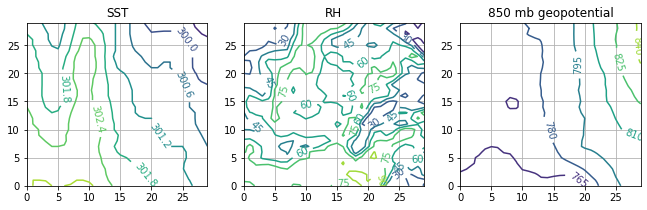

In [11]:
#
# visualize a few variables for checking the input data
#
print("Raw input data shape (nsample,nclass,ny,nx,nchannel) is: ",len(array_raw),len(tcg_class),
    len(array_raw[0][0]),len(array_raw[0][0][0]),len(array_raw[0][0][0][0]))

check_visualization = "yes"
if check_visualization== "yes":
    print("Plotting one example from raw data input")
    temp = np.array(array_raw[7][0])
    plt.figure(figsize=(11, 3)) 
    plt.subplot(1,3,1)
    CS = plt.contour(temp[:,:,4])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('SST')
    plt.grid()

    plt.subplot(1,3,2)
    CS = plt.contour(temp[:,:,1])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('RH')
    plt.grid()

    plt.subplot(1,3,3)
    CS = plt.contour(temp[:,:,9])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('850 mb geopotential')
    plt.grid()

    plt.show()

In [10]:
#
# randomize data and generate training data (X,y)
#
import random
np.random.shuffle(array_raw)
X = []
y = []
for features,label in array_raw: 
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, nchannels)
if check_visualization== "yes":
    print(X.shape)
    print(y)

(704, 30, 30, 12)
[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 

In [5]:
#
# save training data to an output for subsequent use
#
import pickle
pickle_out = open("tcg_ResNet_X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("tcg_ResNet_y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()